# Face Alignment

### Импорт библиотек и начальные установки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
from tqdm.auto import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
import random

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

from datetime import datetime
import time

import albumentations as A
from albumentations.pytorch import ToTensorV2

#from skimage.transform import SimilarityTransform, warp

import gc


In [2]:
# все пути относительны папки текущего проекта
dir_dataset = 'data_CelebA'  # папка с полным датасетом
dir_dataset_mini = 'data_CelebA_mini'  # папка для уменьшенного датасета
dir_images = f'{dir_dataset_mini}/data'  # папка для изображений уменьшенного датасета
dir_aligned_mini = f'{dir_dataset_mini}/data_aligned'  # папка для выровненных изображений уменьшенного датасета


### Анализ набора данных CelebA

In [428]:
# Загрузка данных
df = pd.read_csv(f'{dir_dataset}/list_attr_celeba.csv')
df.sample(10)

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
88263   088264.jpg                -1               -1           1   
112792  112793.jpg                -1               -1           1   
111450  111451.jpg                -1               -1          -1   
11870   011871.jpg                -1                1          -1   
118147  118148.jpg                -1                1          -1   
107025  107026.jpg                 1               -1           1   
131865  131866.jpg                -1               -1          -1   
177865  177866.jpg                -1               -1           1   
73373   073374.jpg                -1               -1          -1   
43360   043361.jpg                -1                1          -1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
88263                -1    -1     -1        -1        -1          -1  ...   
112792               -1    -1     -1        -1        -1          -1  ...   
111450                1    -1     -1        -1        -1          -1  ...   
11870                -1    -1     -1        -1        -1          -1  ...   
118147               -1    -1     -1        -1         1          -1  ...   
107025               -1    -1     -1        -1        -1          -1  ...   
131865               -1    -1     -1        -1        -1          -1  ...   
177865               -1    -1     -1        -1        -1           1  ...   
73373                 1    -1      1        -1         1          -1  ...   
43360                -1    -1     -1         1        -1          -1  ...   

        Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
88263          -1       -1              1         -1                -1   
112792         -1       -1             -1         -1                -1   
111450         -1        1             -1         -1                -1   
11870          -1       -1             -1          1                 1   
118147         -1        1              1         -1                -1   
107025         -1        1             -1          1                -1   
131865         -1        1             -1          1                 1   
177865         -1       -1             -1          1                -1   
73373          -1        1              1         -1                -1   
43360          -1       -1             -1          1                -1   

        Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
88263            -1                -1                -1               -1   
112792           -1                -1                -1               -1   
111450           -1                -1                -1               -1   
11870            -1                 1                -1               -1   
118147           -1                -1                -1               -1   
107025           -1                -1                -1               -1   
131865           -1                 1                -1               -1   
177865           -1                 1                -1               -1   
73373            -1                -1                -1                1   
43360            -1                 1                -1               -1   

        Young  
88263       1  
112792      1  
111450      1  
11870       1  
118147     -1  
107025      1  
131865      1  
177865      1  
73373       1  
43360       1  

[10 rows x 41 columns]

In [13]:
df.describe().T

count      mean       std  min  25%  50%  75%  max
5_o_Clock_Shadow     202599.0 -0.777728  0.628602 -1.0 -1.0 -1.0 -1.0  1.0
Arched_Eyebrows      202599.0 -0.466039  0.884766 -1.0 -1.0 -1.0  1.0  1.0
Attractive           202599.0  0.025010  0.999690 -1.0 -1.0  1.0  1.0  1.0
Bags_Under_Eyes      202599.0 -0.590857  0.806778 -1.0 -1.0 -1.0 -1.0  1.0
Bald                 202599.0 -0.955113  0.296241 -1.0 -1.0 -1.0 -1.0  1.0
Bangs                202599.0 -0.696849  0.717219 -1.0 -1.0 -1.0 -1.0  1.0
Big_Lips             202599.0 -0.518408  0.855135 -1.0 -1.0 -1.0 -1.0  1.0
Big_Nose             202599.0 -0.530935  0.847414 -1.0 -1.0 -1.0 -1.0  1.0
Black_Hair           202599.0 -0.521498  0.853255 -1.0 -1.0 -1.0 -1.0  1.0
Blond_Hair           202599.0 -0.704016  0.710186 -1.0 -1.0 -1.0 -1.0  1.0
Blurry               202599.0 -0.898203  0.439582 -1.0 -1.0 -1.0 -1.0  1.0
Brown_Hair           202599.0 -0.589613  0.807688 -1.0 -1.0 -1.0 -1.0  1.0
Bushy_Eyebrows       202599.0 -0.715665  0.698445 -1.0 -1.0 -1.0 -1.0  1.0
Chubby               202599.0 -0.884866  0.465846 -1.0 -1.0 -1.0 -1.0  1.0
Double_Chin          202599.0 -0.906623  0.421942 -1.0 -1.0 -1.0 -1.0  1.0
Eyeglasses           202599.0 -0.869762  0.493472 -1.0 -1.0 -1.0 -1.0  1.0
Goatee               202599.0 -0.874471  0.485079 -1.0 -1.0 -1.0 -1.0  1.0
Gray_Hair            202599.0 -0.916100  0.400950 -1.0 -1.0 -1.0 -1.0  1.0
Heavy_Makeup         202599.0 -0.226156  0.974093 -1.0 -1.0 -1.0  1.0  1.0
High_Cheekbones      202599.0 -0.089936  0.995950 -1.0 -1.0 -1.0  1.0  1.0
Male                 202599.0 -0.166491  0.986045 -1.0 -1.0 -1.0  1.0  1.0
Mouth_Slightly_Open  202599.0 -0.033144  0.999453 -1.0 -1.0 -1.0  1.0  1.0
Mustache             202599.0 -0.916910  0.399096 -1.0 -1.0 -1.0 -1.0  1.0
Narrow_Eyes          202599.0 -0.769703  0.638404 -1.0 -1.0 -1.0 -1.0  1.0
No_Beard             202599.0  0.669880  0.742471 -1.0  1.0  1.0  1.0  1.0
Oval_Face            202599.0 -0.431715  0.902012 -1.0 -1.0 -1.0  1.0  1.0
Pale_Skin            202599.0 -0.914106  0.405476 -1.0 -1.0 -1.0 -1.0  1.0
Pointy_Nose          202599.0 -0.445111  0.895478 -1.0 -1.0 -1.0  1.0  1.0
Receding_Hairline    202599.0 -0.840443  0.541901 -1.0 -1.0 -1.0 -1.0  1.0
Rosy_Cheeks          202599.0 -0.868558  0.495589 -1.0 -1.0 -1.0 -1.0  1.0
Sideburns            202599.0 -0.886979  0.461811 -1.0 -1.0 -1.0 -1.0  1.0
Smiling              202599.0 -0.035839  0.999360 -1.0 -1.0 -1.0  1.0  1.0
Straight_Hair        202599.0 -0.583196  0.812333 -1.0 -1.0 -1.0 -1.0  1.0
Wavy_Hair            202599.0 -0.360866  0.932620 -1.0 -1.0 -1.0  1.0  1.0
Wearing_Earrings     202599.0 -0.622150  0.782900 -1.0 -1.0 -1.0 -1.0  1.0
Wearing_Hat          202599.0 -0.903079  0.429475 -1.0 -1.0 -1.0 -1.0  1.0
Wearing_Lipstick     202599.0 -0.055129  0.998482 -1.0 -1.0 -1.0  1.0  1.0
Wearing_Necklace     202599.0 -0.754066  0.656800 -1.0 -1.0 -1.0 -1.0  1.0
Wearing_Necktie      202599.0 -0.854570  0.519338 -1.0 -1.0 -1.0 -1.0  1.0
Young                202599.0  0.547234  0.836982 -1.0  1.0  1.0  1.0  1.0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [6]:
df.isnull().values.any()

np.False_

In [6]:
df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [429]:
def load_and_display_image(image_name, base_dir='data_CelebA'):
    """
    Загружает и отображает изображение из датасета CelebA по его имени.
    
    Args:
        image_name (str): Имя изображения (например, "000001.jpg")
        base_dir (str): Базовая директория, содержащая папки Part 1, Part 2 и т.д.
        
    Returns:
        PIL.Image: Загруженное изображение
    """

    # извлекаем числовой номер из имени файла
    file_number = int(image_name.split('.')[0])
    
    # Определяем номер части на основе числового номера файла
    # Для файлов 1-10000: Part 1
    # Для файлов 10001-20000: Part 2
    # ...
    # Для файлов 200001-202599: Part 21
    part_number = (file_number - 1) // 10000 + 1
    
    # путь к файлу
    part_folder = f"Part {part_number}"
    image_path = os.path.join(base_dir, part_folder, part_folder, image_name)
        
    # загружаем изображение
    img = Image.open(image_path)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{image_name} (Part {part_number})")
    plt.tight_layout()
    plt.show()
    
    #return img # в jupyter возврат изображения автоматически его отображает

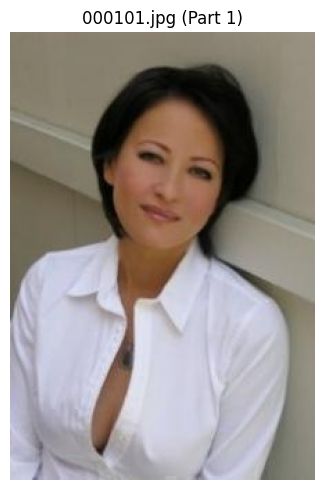

In [5]:
load_and_display_image("000101.jpg")

__Посмотрим на изображения, фильтруя их по атрибутам__

In [7]:
def compare_attribute(attribute_name, df=df, base_dir='data_CelebA'):
    """
    Отображает два изображения для сравнения: одно с указанным атрибутом, другое - без него.
    
    Args:
        attribute_name (str): Название атрибута из CSV файла (например, 'Eyeglasses')
        df (pd.DataFrame): DataFrame с атрибутами из list_attr_celeba.csv
        base_dir (str): Базовая директория с изображениями
    """
    
    # Находим изображения с атрибутом (значение 1) и без атрибута (значение -1)
    with_attr = df[df[attribute_name] == 1]
    without_attr = df[df[attribute_name] == -1]
        
    # Выбираем случайные изображения
    img_with = with_attr.sample(1).iloc[0]['image_id']
    img_without = without_attr.sample(1).iloc[0]['image_id']
    
    # функция для загрузки изображения по его имени
    def load_image(image_name):
        file_number = int(image_name.split('.')[0])
        part_number = (file_number - 1) // 10000 + 1
        part_folder = f"Part {part_number}"
        image_path = os.path.join(base_dir, part_folder, part_folder, image_name)
        return Image.open(image_path)
    
    img1 = load_image(img_with)
    img2 = load_image(img_without)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(img1)
    axes[0].set_title(f"С атрибутом '{attribute_name}'\n{img_with}", fontsize=10, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(img2)
    axes[1].set_title(f"Без атрибута '{attribute_name}'\n{img_without}", fontsize=10, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

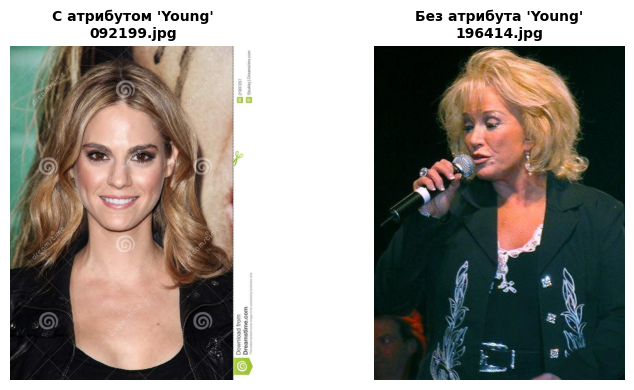

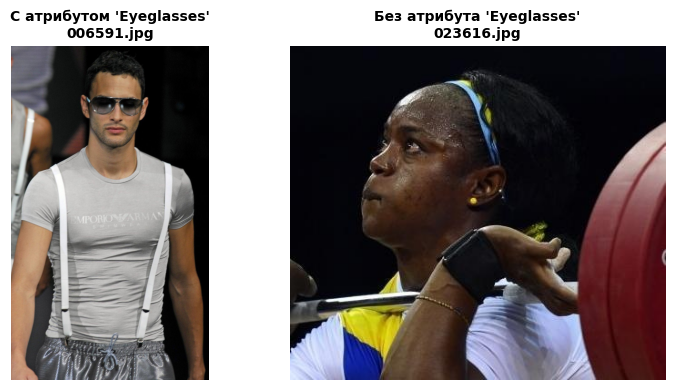

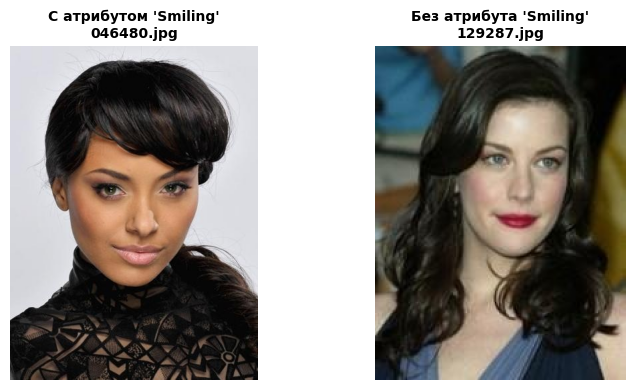

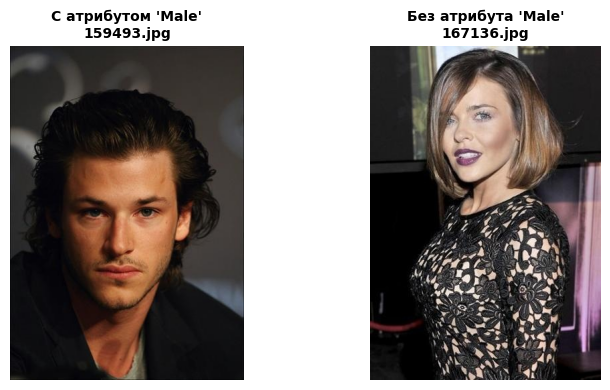

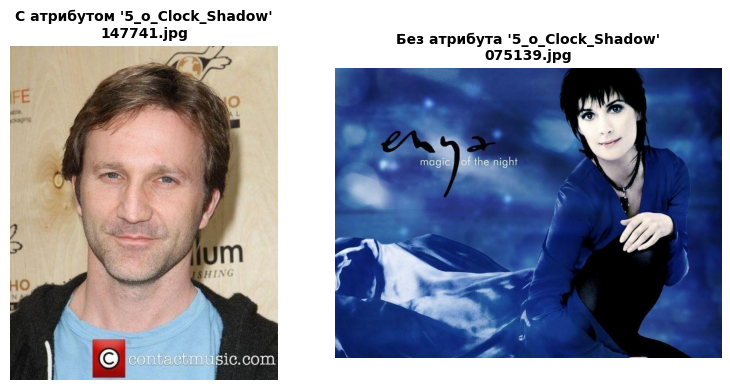

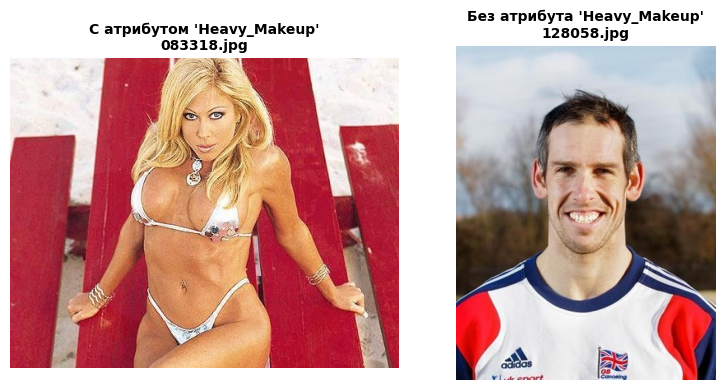

In [8]:
compare_attribute('Young')
compare_attribute('Eyeglasses')
compare_attribute('Smiling')
compare_attribute('Male')
compare_attribute('5_o_Clock_Shadow')
compare_attribute('Heavy_Makeup')

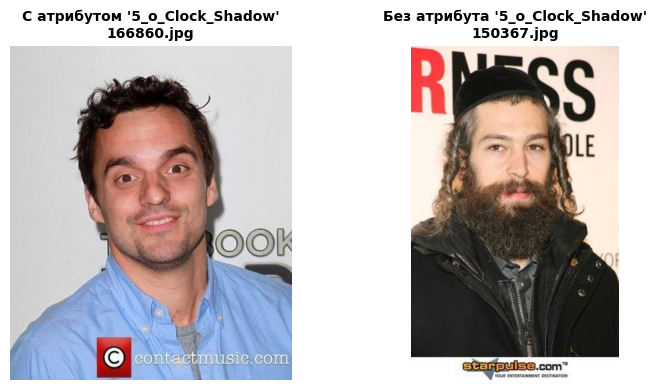

In [72]:
compare_attribute('5_o_Clock_Shadow')

In [82]:
df.loc[df['image_id'].isin(['150367.jpg', '166860.jpg']), ['No_Beard', 'Mustache', '5_o_Clock_Shadow']]

No_Beard  Mustache  5_o_Clock_Shadow
150366        -1        -1                -1
166859        -1        -1                 1

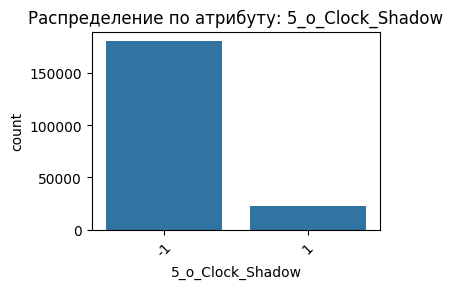

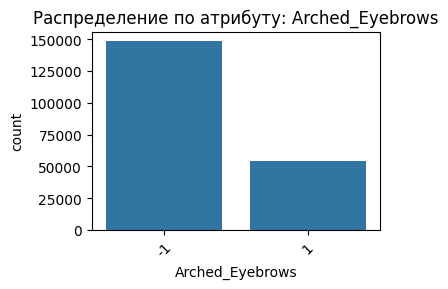

In [35]:
for col in df.columns[1:3]:
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df, x=col)
    plt.title(f'Распределение по атрибуту: {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

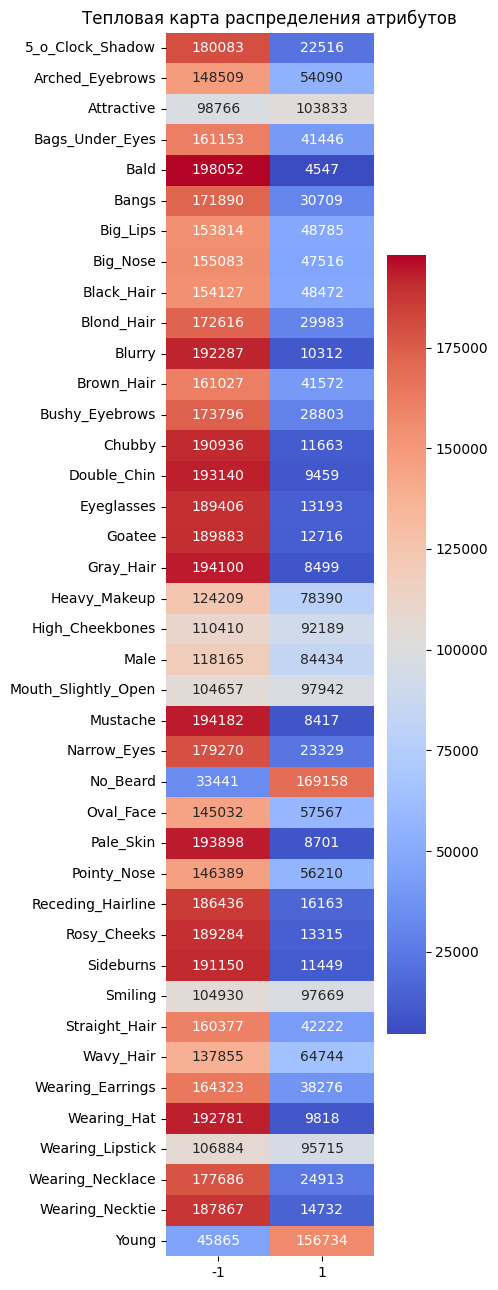

In [ ]:
# Тепловая карту распределений атрибутов
plt.figure(figsize=(5, 13))
sns.heatmap(df.iloc[:, 1:].apply(pd.Series.value_counts).T, annot=True, cmap='coolwarm', fmt='.0f')
plt.title('Тепловая карта распределения атрибутов')
plt.tight_layout()
plt.show()

В датасете примерно поровну представлены люди с/без: большими губами, носами, брюнетки(-ты), блондинки(-ны), шатенки(-ны), с макияжем, с помадой, высокими лбами, мужчины/женщины, закрытыми/открытыми ртами, улыбающиеся, молодые.

Также можно попробовать сгруппировать атрибуты по степени их влияния на качество распознвания:

1. Очень важные: Male, Young, Eyeglasses, Bald, Blurry (качество изображения).

2. Важные: 5_o_Clock_Shadow (щетина), Heavy_Makeup, Wearing_Hat, Mustache, Goatee, Sideburns, Mouth_Slightly_Open, Smiling, Narrow_Eyes, Arched_Eyebrows, Bushy_Eyebrows (форма бровей), Big_Nose, Pointy_Nose (форма носа), High_Cheekbones (скулы, атрибут важен для распознавания).

3. Средней важности:
Black_Hair, Blond_Hair, Brown_Hair, Gray_Hair - цвет волос может влиять на распознавание
Straight_Hair, Wavy_Hair - тип волос влияет на контуры лица
Receding_Hairline - изменяет форму головы
Wearing_Earrings, Wearing_Necklace - ювелирные изделия могут влиять на распознавание
Wearing_Lipstick - изменяет восприятие губ
Oval_Face - форма лица
Bags_Under_Eyes - мешки под глазами (например, признаки усталости) могут влиять на распознавание
Pale_Skin, Rosy_Cheeks - тон кожи

4. Низкая важность для распознавания:
Attractive (привлекательность субъективный атрибут и непонятно как может повлиять на распознавание), Big_Lips (современные модели распознавания на глобальные признаки), Bangs (чёлка, закрытие части лба учитываем шляпами), Chubby, Double_Chin.


### Выборка изображений - формирование мини набора данных для последующего обучения нейросетей

На основании проведенных многочисленных экспериментов для выборки используем наиболее распространенные признаки, наиболее сильно влияющих на распознавание лиц и которые не катастрофически сокращают количество персон (личностей) в наборе данных, что критично для последующей тренировки нейросети распознавания лиц.

In [ ]:
# выбор атрибутов для отбора изображений

attrs_1 = ['Male', 'Young', 'Eyeglasses', 'Bald', 'Blurry']

attrs_2 = [
'5_o_Clock_Shadow', 'Mouth_Slightly_Open', 'Heavy_Makeup', 'Wearing_Hat',
'Smiling', 'Narrow_Eyes', 'Arched_Eyebrows', 'Bushy_Eyebrows',
'Big_Nose', 'Pointy_Nose', 'High_Cheekbones'
]

#attrs_3 = ['Wearing_Earrings', 'Wearing_Lipstick', 'Oval_Face', 'Chubby', 'Bags_Under_Eyes']

# объединяем атрибуты для стратификации
key_attrs = attrs_1 + attrs_2

# желаемый размер выборки
target_size = 10000

# минимальное количество изображений для каждой персоны
min_images_per_person = 20

# Допускаем превышение до 1000 изображений
max_allowed_size = target_size + 1000

Делаем стратифицированную выборку с учетом идентификаторов персон (используем файл идентификаторов изображений)

In [527]:
# добавляем колонку для стратификации
df['stratum'] = df[key_attrs].astype(str).agg('_'.join, axis=1)

# загружаем файл с идентификаторами персон
identity_df = pd.read_csv(f'{dir_dataset}/identity_CelebA.txt', sep='\s+', header=None, names=['image_id', 'person_id'])

# сливаем персоны с их изображениями
df_with_person = df.merge(identity_df, on='image_id', how='left')

# фильтруем страты с достаточным количеством изображений по персонам и в каждой страте
person_counts = df_with_person['person_id'].value_counts()
valid_persons = person_counts[person_counts >= min_images_per_person].index

stratum_counts = df_with_person['stratum'].value_counts()
valid_strata = stratum_counts[stratum_counts >= 2].index

# фильтруем данные
df_final = df_with_person[
    (df_with_person['person_id'].isin(valid_persons)) & 
    (df_with_person['stratum'].isin(valid_strata))
].copy()

# заново проверяем, что у каждой персоны в выборке достаточно изображений
person_counts_final = df_final['person_id'].value_counts()
valid_persons_final = person_counts_final[person_counts_final >= min_images_per_person].index
df_final = df_final[df_final['person_id'].isin(valid_persons_final)].copy()


# группируем по персонам
person_groups = list(df_final.groupby('person_id'))
# cортируем по убыванию количества изображений
person_groups.sort(key=lambda x: len(x[1]), reverse=True)
# количество персон
total_persons = len(person_groups)
# вычисляем сколько персон можно взять из датасета при установленном ограничении
if total_persons * min_images_per_person > max_allowed_size:
    max_persons = max_allowed_size // min_images_per_person
    person_groups = person_groups[:max_persons] # обрезаем датасет по выбранным персонам
    total_persons = max_persons

# общий размер датасета из выбранных групп
total_images_in_selected_groups = sum(len(group) for _, group in person_groups)

# теперь для каждой группы стратифицированно отбираем изображения
selected_images = []
for person_id, group in person_groups:
    # определяем весовой коэффициент этой группы
    person_ratio = len(group) / total_images_in_selected_groups
    # из общего количества изображений вычитаем базовое количество (по 20 изображений на каждого человека/персону/группу) и берем оттуда количество изображений согласно веса этой группы
    additional_count = int((target_size - total_persons * min_images_per_person) * person_ratio)
    # тогда целевое количество изображений для этой группы будет минимальное количество + доп.
    target_count = min_images_per_person + additional_count
    target_count = max(min_images_per_person, min(target_count, len(group)))
    # стратифицированный отбор изображений для текущей группы
    try:
        _, person_samples = train_test_split(
            group,
            test_size=target_count / len(group),
            stratify=group['stratum_reduced'],
            random_state=4242
        )
    except:
        # если нет страт, только одна страта или какая-то ошибка, то берем случайную выборку
        person_samples = group.sample(n=target_count, random_state=4242)
    # добавляем в список выбранных изображений
    selected_images.append(person_samples)

mini_df = pd.DataFrame()
# объединяем результаты в общий датасет
mini_df = pd.concat(selected_images)

# проверка: если изображений получилось меньше target_size, то добавим недостающие изображения
if len(mini_df) < target_size:
    print(f"Не хватило {target_size - len(mini_df)} изображений")
    remaining_needed = min(max_allowed_size - len(mini_df), target_size - len(mini_df))
    # недостающие изображения возмем из оставшихся в выбранных группах
    remaining_indices = df_final.index[~df_final.index.isin(mini_df.index)]
    if len(remaining_indices) > 0:
        remaining_candidates = df_final.loc[remaining_indices]
        additional_samples = remaining_candidates.sample(n=min(remaining_needed, len(remaining_candidates)), random_state=4242)
        mini_df = pd.concat([mini_df, additional_samples])


print(f"Количество изображений после фильтрации персон: {len(df_filtered_persons)}")
print(f"Количество изображений после фильтрации страт: {len(df_final)}")
print(f"Количество уникальных страт после фильтрации: {df_final['stratum'].nunique()}")
print(f"Количество персон после финальной фильтрации: {len(valid_persons_final)}")
print(f"Количество изображений после финальной фильтрации: {len(df_final)}")
print(f"Итоговое количество изображений: {len(mini_df)}")
print(f"Количество уникальных персон: {mini_df['person_id'].nunique()}")
print(f"Минимальное количество изображений на персону: {mini_df['person_id'].value_counts().min()}")
print(f"Максимальное количество изображений на персону: {mini_df['person_id'].value_counts().max()}")

Количество изображений после фильтрации персон: 163749
Количество изображений после фильтрации страт: 160761
Количество уникальных страт после фильтрации: 3016
Количество персон после финальной фильтрации: 6243
Количество изображений после финальной фильтрации: 160761
Итоговое количество изображений: 11000
Количество уникальных персон: 550
Минимальное количество изображений на персону: 20
Максимальное количество изображений на персону: 20


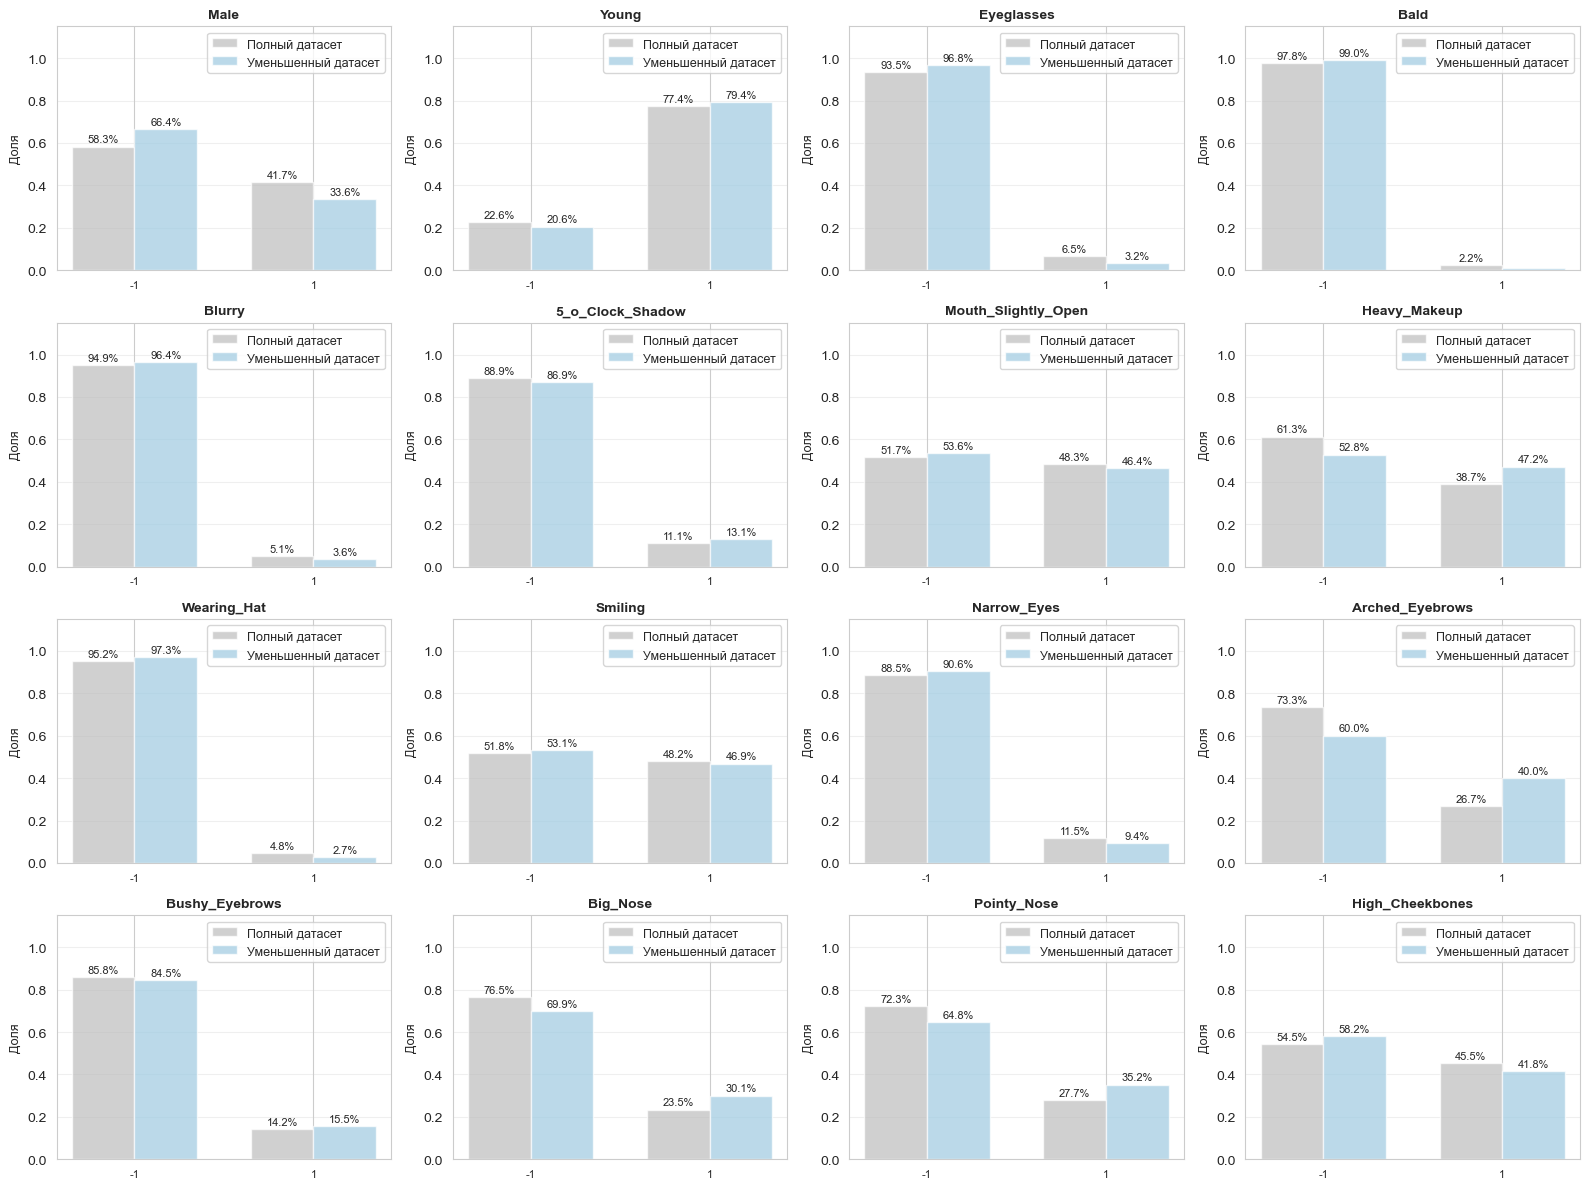

In [528]:
# Визуализация распределений признаков в полном и уменьшенном датасетах

n_cols = 4
cl_full = '#bdbdbd'    # Средний серый
cl_mini = '#9ecae1'    # Светлый синий

n_rows = (len(key_attrs) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
axes = axes.flatten()

for i, attr in enumerate(key_attrs):
    ax = axes[i]
    
    # распределение в полном датасете
    full_counts = df[attr].value_counts(normalize=True)
    # распределение в уменьшенном датасете
    mini_counts = mini_df[attr].value_counts(normalize=True)
    
    # получаем все уникальные значения
    all_values = sorted(set(full_counts.index.tolist() + mini_counts.index.tolist()))
    
    x = np.arange(len(all_values))
    width = 0.35
    
    # столбцы
    bars1 = ax.bar(x - width/2, [full_counts.get(val, 0) for val in all_values], 
                  width, label='Полный датасет', alpha=0.7, color=cl_full)
    bars2 = ax.bar(x + width/2, [mini_counts.get(val, 0) for val in all_values], 
                  width, label='Уменьшенный датасет', alpha=0.7, color=cl_mini)
    
    # подписи в процентах
    for bar in bars1:
        height = bar.get_height()
        if height > 0.01:  # Подписываем только если значение > 1%
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height*100:.1f}%', 
                   ha='center', va='bottom', fontsize=8)
    
    for bar in bars2:
        height = bar.get_height()
        if height > 0.01:  # Подписываем только если значение > 1%
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height*100:.1f}%', 
                   ha='center', va='bottom', fontsize=8)
    
    ax.set_title(attr, fontsize=10, fontweight='bold')
    ax.set_ylabel('Доля', fontsize=9)
    ax.set_xticks(x)
    ax.set_xticklabels([str(val) for val in all_values], fontsize=8)
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.15)  # место для подписей

# удаляем пустые подграфики
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(f'{dir_dataset_mini}/attributes_distribution.png', bbox_inches='tight', dpi=100)
plt.show()

__Итак, считаем, что полученный уменьшенный датасет отвечает требованиям стратифицированной выборки, а также включает достаточно изображений каждой персоны для обучения моделей распознавания.__

*Примечание. Если выполнять просто стратифицированный отбор, то качество соответствия малого датасета большому будет очень высоким (1-3% отклонение по признакам), но тогда чаще всего получается, что каждый человек/персона представлен только одним изображением, и в будущем при обучении нейросети распознавания лиц непонятно как модель будет учиться определять изображения одного и того же человека (ведь все изображения разные, у модели не будет подходящих образцов изображений)*

__Следующий шаг - формируем датасеты метаданных уменьшенного датасета и копируем только выбранные изображений в отдельную папку (создаем полноценный мини датасет).__

In [529]:
# Загрузка дополнительных файлов с аннотациями
bbox_df = pd.read_csv(f'{dir_dataset}/list_bbox_celeba.csv')
landmarks_df = pd.read_csv(f'{dir_dataset}/list_landmarks_celeba.txt', sep='\s+', skiprows=1).reset_index() # это файл с метками ДО выравнивания
landmarks_df.rename(columns={landmarks_df.columns[0]: 'image_id'}, inplace=True)

# фильтрация по выбранным изображениям
mini_bbox_df = bbox_df[bbox_df['image_id'].isin(mini_df['image_id'])].copy()
mini_landmarks_df = landmarks_df[landmarks_df['image_id'].isin(mini_df['image_id'])].copy()
mini_identity_df = identity_df[identity_df['image_id'].isin(mini_df['image_id'])]

assert len(mini_identity_df) == len(mini_df), "Несоответствие количества изображений в identity"
assert len(mini_bbox_df) == len(mini_df), "Несоответствие количества изображений в bounding boxes"
assert len(mini_landmarks_df) == len(mini_df), "Несоответствие количества изображений в landmarks"

# сортировка для соответствия порядку в mini_df
mini_bbox_df = mini_bbox_df.set_index('image_id').loc[mini_df['image_id']].reset_index()
mini_landmarks_df = mini_landmarks_df.set_index('image_id').loc[mini_df['image_id']].reset_index()

In [530]:
# cохраняем все уменьшенные датасеты
mini_df.to_csv(f'{dir_dataset_mini}/list_attr_celeba_mini.csv', index=False)
mini_bbox_df.to_csv(f'{dir_dataset_mini}/list_bbox_celeba_mini.csv', index=False)
mini_landmarks_df.to_csv(f'{dir_dataset_mini}/list_landmarks_celeba_mini.csv', index=False)
mini_identity_df.to_csv(f'{dir_dataset_mini}/identity_CelebA_mini.csv', index=False)

In [531]:
# копируем изображения в папку с уменьшенным датасетом

if not os.path.exists(dir_images):
    os.makedirs(dir_images)

for idx, row in tqdm(mini_df.iterrows(), total=len(mini_df)):
    image_name = row['image_id']
    
    # определяем номер части по номеру изображения
    file_number = int(image_name.split('.')[0])
    part_number = (file_number - 1) // 10000 + 1
    
    # путь к исходному изображению
    part_folder = f"Part {part_number}"
    src_path = os.path.join(dir_dataset, part_folder, part_folder, image_name)
    
    # Формируем путь к целевому изображению
    dst_path = os.path.join(dir_images, image_name)
    
    # Копируем файл, если он существует
    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)
    else:
        print(f"Файл не найден: {src_path}")

print(f"Скопировано изображений: {len(os.listdir(dir_images))}")

100%|██████████| 11000/11000 [00:03<00:00, 2776.21it/s]

Скопировано изображений: 11000


__Минидатасет создан!__

### Анализ разметки ключевых точек лица

В разметке CelebA всего 5 точек:

1. Левый глаз
2. Правый глаз
3. Нос
4. Левый уголок рта
5. Правый уголок рта


Единственная проблема заключается в том, что разметка - это именно точки, а не heatmap'ы.

Но можно их сгенерировать самостоятельно при помощи гауссовского распределения вокруг размеченных точек.

In [524]:
def create_heatmap(size, landmark, sigma=2):
    """
    Создаёт один heatmap с гауссовым ядром вокруг точки.

    :param size: (height, width) — размер heatmap'а
    :param landmark:(x, y) — координаты точки
    :param sigma
    :return: heatmap массив
    """
    x, y = landmark
    h, w = size

    # Обрезаем координаты, чтобы не выйти за пределы изображения
    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
    return heatmap


def landmarks_to_heatmaps(image_shape, landmarks, sigma=2):
    """
    Преобразует список из N точек в набор из N heatmap'ов.

    :param image_shape: исходный размер изображения (H, W)
    :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN),]
    :param sigma:
    :return: массив heatmap'ов вида [N, H, W]
    """
    heatmaps = []

    for landmark in landmarks:
        hm = create_heatmap(image_shape, landmark, sigma=sigma)
        heatmaps.append(hm)

    return np.array(heatmaps)

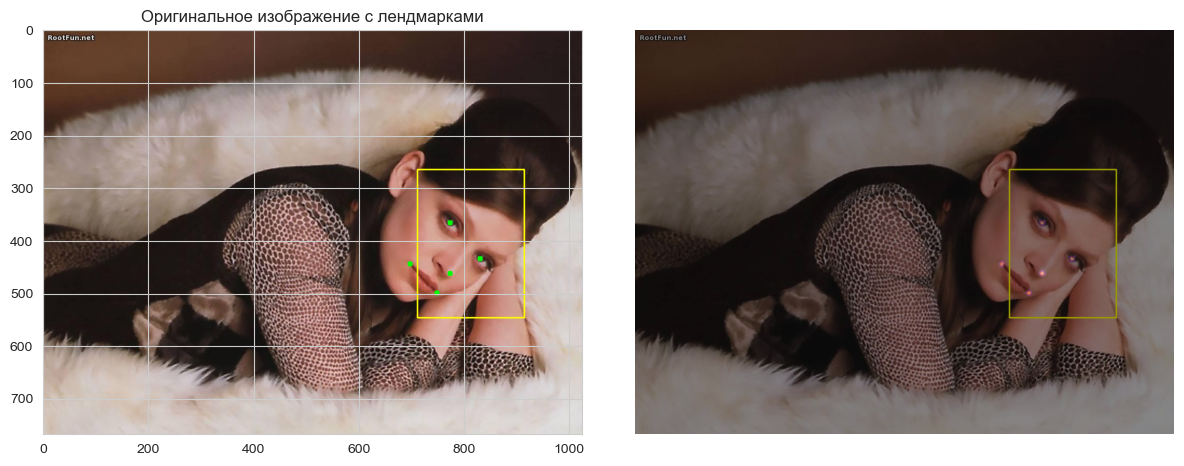

In [547]:
# выбираем случайное изображение для визуализации ландмарков
image_name = random.choice(mini_df['image_id'].to_list())
row_bbox = mini_bbox_df[mini_bbox_df['image_id'] == image_name].iloc[0]
row_lm = mini_landmarks_df[mini_landmarks_df['image_id'] == image_name].iloc[0]

# загружаем изображение
image = cv2.imread(os.path.join(dir_images, image_name))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h_img, w_img = image_rgb.shape[:2]

# cобираем landmarks
landmarks = np.array([
    [row_lm['lefteye_x'], row_lm['lefteye_y']],
    [row_lm['righteye_x'], row_lm['righteye_y']],
    [row_lm['nose_x'], row_lm['nose_y']],
    [row_lm['leftmouth_x'], row_lm['leftmouth_y']],
    [row_lm['rightmouth_x'], row_lm['rightmouth_y']],
])

# собираем bbox
bbox = np.array([
    [row_bbox['x_1'], row_bbox['y_1']],
    [row_bbox['x_1'] + row_bbox['width'], row_bbox['y_1'] + row_bbox['height']]
])

# визуализируем оригинал с лендмарками и ббоксом
image_disp = image_rgb.copy()
for (lx, ly) in landmarks.astype(int):
    cv2.circle(image_disp, (lx, ly), radius=5, color=(0, 255, 0), thickness=-1)
cv2.rectangle(image_disp, bbox[0].astype(int), bbox[1].astype(int), color=(255, 255, 0), thickness=2)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_disp)
plt.title("Оригинальное изображение с лендмарками")

# создаём heatmaps на всём изображении
heatmaps = landmarks_to_heatmaps((h_img, w_img), landmarks, sigma=3)

# визуализируем heatmaps
plt.subplot(1, 2, 2)
image_with_bbox = image_rgb.copy()
cv2.rectangle(image_with_bbox, bbox[0].astype(int), bbox[1].astype(int), color=(255, 255, 0), thickness=2)
plt.imshow(image_with_bbox)
plt.imshow(np.sum(heatmaps, axis=0), cmap='magma', alpha=0.4)  # накладываем heatmap на изображение
plt.tight_layout()
plt.axis("off")
plt.show()

__Примечание:__ на некоторых изображениях не очень аккуратно определен bbox - он не захватывает все лицо и какой-то landmark может быть за пределами bbox, а, значит, и за пределами изображения после обрезки. Также на некоторых изображениях bbox определен слишком "широко" и захватывает кроме лица еще дополнительные элементы. Такие погрешности в подготовке набора данных в будущем наверняка скажутся на качестве нейросетевых моделей. С другой стороны такие ошибки подготовки изображений позволяют моделям "увидеть" не идеальные изображения и результат на тесте может быть выше результатов моделей, обученных на идеальных данных. Далее будем работать с тем, что есть без серьезной коррекции bbox'ов.

### Класс-датасет для загрузки подготовленных изображений (обрезаны по bbox, смасштабированы ны scale, landmarks пересчитаны)

In [ ]:
class LandmarkDataset(torch.utils.data.Dataset):
    def __init__(self, image_ids, bbox_df, landmarks_df, images_dir, 
                 bbox_cols=None, landmark_cols=None, 
                 bbox_format="xywh",  # "xywh" или "xyxy"
                 scale=0.9,
                 size=(112, 112),
                 heatmap_size=(28, 28),
                 sigma=2,
                 augment=True, 
                 return_original=True):
        """
        Args:
            image_ids: список имен файлов изображений (например, ['img1.jpg', 'img2.jpg', ...])
            bbox_df: DataFrame включающий bounding boxes с колонкой 'image_id' с именами файлов изображений
            landmarks_df: DataFrame включающий landmarks с колонкой 'image_id' с именами файлов изображений
            images_dir: путь к папке с изображениями
            bbox_cols: список колонок координат bbox (если None, то будут использованы все числовые колонки)
            landmark_cols: список колонок координат landmark (если None, то будут использованы все числовые колоноки)
            bbox_format: формат bounding boxes - "xywh" (x_min, y_min, width, height) 
                                             или "xyxy" (x_min, y_min, x_max, y_max)
            scale: коэффициент масштабирования bbox (0.9 означает уменьшение на 10%)
            size: целевой размер изображения (height, width)
            heatmap_size: размер heatmaps (height, width)
            sigma: стандартное отклонение для гауссова ядра в heatmaps
            augment: флаг включения аугментаций (True для тренировки, False для валидации/теста)
            return_original: если True, то возвращать оригинальные изображения и координаты
        """

        self.image_ids = image_ids
        self.images_dir = images_dir
        self.scale = scale
        self.size = size  # Финальный размер изображения (112, 112)
        self.augment = augment
        self.return_original = return_original
        self.heatmap_size = heatmap_size
        self.sigma = sigma
        
        # проверка формата bbox_format
        self.bbox_format = bbox_format.lower()
        valid_formats = ["xywh", "xyxy"]
        if self.bbox_format not in valid_formats:
            raise ValueError(f"bbox_format должен быть одним из {valid_formats}, но получен {bbox_format}")
                
        # получаем колонки координат bbox
        if bbox_cols is None:
            bbox_cols = [col for col in bbox_df.columns if col != 'image_id' and np.issubdtype(bbox_df[col].dtype, np.number)]
        self.bbox_cols = bbox_cols
        
        # получаем колонки landmarks
        if landmark_cols is None:
            landmark_cols = [col for col in landmarks_df.columns if col != 'image_id' and np.issubdtype(landmarks_df[col].dtype, np.number)]
        self.landmark_cols = landmark_cols
        
        # устанавливаем индексы в датасетах для ускорения работы
        self.bbox_df = bbox_df.set_index('image_id')
        self.landmarks_df = landmarks_df.set_index('image_id')
        
        # фильтруем датасеты - оставляем данные только по переданному списку изображений
        self.bbox_df = self.bbox_df.loc[self.bbox_df.index.intersection(self.image_ids)]
        self.landmarks_df = self.landmarks_df.loc[self.landmarks_df.index.intersection(self.image_ids)]
        
        # обновляем список image IDs, чтобы включить только те изображения, для которых есть bbox И landmarks
        common_ids = list(set(self.bbox_df.index).intersection(set(self.landmarks_df.index)))
        self.image_ids = [img_id for img_id in self.image_ids if img_id in common_ids]
        
        if len(self.image_ids) == 0:
            warnings.warn("Нет ни одного изображения с оформленными bbox и landmarks. Датасет будет пустым.")
        
        # считаем количество landmarks
        self.num_landmarks = len(self.landmark_cols) // 2    # на каждую точку требуется 2 координаты
        
        # трансформации изображения в зависимости от режима
        if augment:            
            self.transform = A.Compose([
                # цветовые аугментации
                A.RandomBrightnessContrast(brightness_limit=0.08, contrast_limit=0.08, p=0.4),
                
                # шум
                A.GaussNoise(std_range=(0.05, 0.15), p=0.3), 
                
                # поворот и легкое масштабирование
                A.Affine(
                    scale=(0.98, 1.02),  # очень умеренное масштабирование
                    translate_percent={"x": (-0.02, 0.02), "y": (-0.02, 0.02)},  # небольшие сдвиги
                    rotate=(-7, 7),  # умеренные повороты (человек может так поворачивать голову)
                    interpolation=cv2.INTER_LINEAR,
                    border_mode=cv2.BORDER_CONSTANT, 
                    fill=0,
                    p=0.8
                ),

                # ресайз
                A.LongestMaxSize(
                    max_size=max(size), 
                    interpolation=cv2.INTER_LINEAR
                ),
                A.PadIfNeeded(
                    min_height=size[0], 
                    min_width=size[1], 
                    border_mode=cv2.BORDER_CONSTANT, 
                    fill=0
                ),
                # нормализация для ResNet
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
                ToTensorV2()
            ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
        else:
            # трансформации для валидации/теста
            self.transform = A.Compose([
                A.LongestMaxSize(max_size=max(size), interpolation=cv2.INTER_LINEAR, p=1.0),
                A.PadIfNeeded(
                    min_height=size[0], 
                    min_width=size[1], 
                    border_mode=cv2.BORDER_CONSTANT, 
                    fill=0,
                    p=1.0
                ),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


    def __len__(self):
        return len(self.image_ids)


    def _apply_transforms(self, image, bbox, landmarks):
        """
        Применяем сначала кроп по bbox, затем аугментации с сохранением фиксированного размера
        """
        # получаем размеры bbox
        if self.bbox_format == "xywh":
            x_min, y_min, width, height = bbox
            x_max, y_max = x_min + width, y_min + height
        else:  # "xyxy"
            x_min, y_min, x_max, y_max = bbox
        
        # центр bbox
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        
        # масштабируем bbox относительно центра
        new_width = bbox_width * self.scale
        new_height = bbox_height * self.scale
        new_x_min = center_x - new_width / 2
        new_y_min = center_y - new_height / 2
        new_x_max = center_x + new_width / 2
        new_y_max = center_y + new_height / 2
        
        # приводим координаты к целым числам и проверяем границы изображения
        h_img, w_img = image.shape[:2]
        new_x_min = max(0, int(new_x_min))
        new_y_min = max(0, int(new_y_min))
        new_x_max = min(w_img, int(new_x_max))
        new_y_max = min(h_img, int(new_y_max))
        
        # обрезаем изображение по новому bbox
        cropped_image = image[new_y_min:new_y_max, new_x_min:new_x_max].copy()
        height, width = cropped_image.shape[:2]
        
        # корректируем координаты landmarks
        landmarks[:, 0] -= new_x_min
        landmarks[:, 1] -= new_y_min

        # обрезаем координаты landmarks по границам кадрированного изображения
        landmarks[:, 0] = np.clip(landmarks[:, 0], 0, width - 1e-5)
        landmarks[:, 1] = np.clip(landmarks[:, 1], 0, height - 1e-5)
        
        # применяем трансформации
        transformed = self.transform(
            image=cropped_image,
            keypoints=landmarks.tolist()
        )
        
        transformed_image = transformed['image']  # Это тензор [3, 112, 112]
        transformed_landmarks = np.array(transformed['keypoints'])

        return transformed_image, transformed_landmarks


    def _generate_heatmaps(self, landmarks):
        """
        Создаёт heatmaps с гауссовым ядром вокруг точек landmarks.
        landmarks - numpy массив после трансформаций
        ВСЕГДА используем фиксированный размер self.size для нормализации
        """
        heatmaps = []

        img_h, img_w = self.size  # (112, 112) - гарантируется трансформациями
        
        for landmark in landmarks:
            # нормализуем координаты landmarks к размеру heatmap
            x = landmark[0] * self.heatmap_size[1] / img_w  # ширина heatmap
            y = landmark[1] * self.heatmap_size[0] / img_h  # высота heatmap
            
            # округляем и проверяем границы
            x = int(round(x))
            y = int(round(y))
            x = max(0, min(x, self.heatmap_size[1] - 1))  # ширина
            y = max(0, min(y, self.heatmap_size[0] - 1))  # высота
            
            # создаем гауссову heatmap
            xx, yy = np.meshgrid(np.arange(self.heatmap_size[1]), np.arange(self.heatmap_size[0]))
            hm = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * self.sigma**2))
            heatmaps.append(hm)
            
        return torch.tensor(np.array(heatmaps), dtype=torch.float)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]

        # загружаем изображение
        img_path = os.path.join(self.images_dir, img_id)
        try:
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Файл {img_path} не найден")
            # открываем изображение
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Ошибка загрузки изображения {img_path}: {str(e)}")
        
        # получаем bbox и landmarks для текущего изображения
        bbox = self.bbox_df.loc[img_id, self.bbox_cols].values.astype(np.float32)
        landmarks = self.landmarks_df.loc[img_id, self.landmark_cols].values.astype(np.float32)
        landmarks = landmarks.copy().reshape(-1, 2)
        
        # применяем трансформации (возвращает тензор и landmarks)
        transformed_image, transformed_landmarks = self._apply_transforms(
                np.array(image), bbox.copy(), landmarks.copy()
            )
        
        # конвертируем landmarks в тензор
        transformed_landmarks_tensor = torch.tensor(transformed_landmarks, dtype=torch.float32).view(self.num_landmarks, 2)
        
        # создаём heatmaps на основе трансформированных landmarks
        heatmaps = self._generate_heatmaps(transformed_landmarks)

        result = {
            'image': transformed_image,  # Гарантированно тензор [3, 112, 112]
            'landmarks': transformed_landmarks_tensor,  # [5, 2]
            'heatmaps': heatmaps,  # [5, 28, 28]
            'image_id': img_id
        }
        
        if self.return_original:
            bbox_tensor = torch.tensor(bbox, dtype=torch.float32)
            landmarks_tensor = torch.tensor(landmarks, dtype=torch.float32).view(self.num_landmarks, 2)
            result.update({
                'original_bbox': bbox_tensor,
                'original_landmarks': landmarks_tensor
            })
        
        return result

In [549]:
IMAGE_SIZE = (112, 112)
HEATMAP_SIZE = (28, 28)
SCALE = 0.9


# загружаем датафреймы данных для уменьшенного датасета
mini_df = pd.read_csv(f'{dir_dataset_mini}/list_attr_celeba_mini.csv')
mini_bbox_df = pd.read_csv(f'{dir_dataset_mini}/list_bbox_celeba_mini.csv')
mini_landmarks_df = pd.read_csv(f'{dir_dataset_mini}/list_landmarks_celeba_mini.csv')
mini_identity_df = pd.read_csv(f'{dir_dataset_mini}/identity_CelebA_mini.csv')


all_image_ids = mini_df['image_id'].to_list()

# разделяем на train и temp
train_ids, temp_ids = train_test_split(all_image_ids, test_size=0.3, random_state=11)

# разделяем temp на test и val
test_ids, val_ids = train_test_split(temp_ids, test_size=0.5, random_state=11)

# создаем датасеты
train_dataset = LandmarkDataset(train_ids, mini_bbox_df, mini_landmarks_df, dir_images, size=IMAGE_SIZE, heatmap_size=HEATMAP_SIZE, scale=SCALE, augment=True)
test_dataset = LandmarkDataset(test_ids, mini_bbox_df, mini_landmarks_df, dir_images, size=IMAGE_SIZE, heatmap_size=HEATMAP_SIZE, scale=SCALE, augment=False)
val_dataset = LandmarkDataset(val_ids, mini_bbox_df, mini_landmarks_df, dir_images, size=IMAGE_SIZE, heatmap_size=HEATMAP_SIZE, scale=SCALE, augment=False)

In [550]:
BATCH_SIZE = 64

# определяем даталоадеры
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

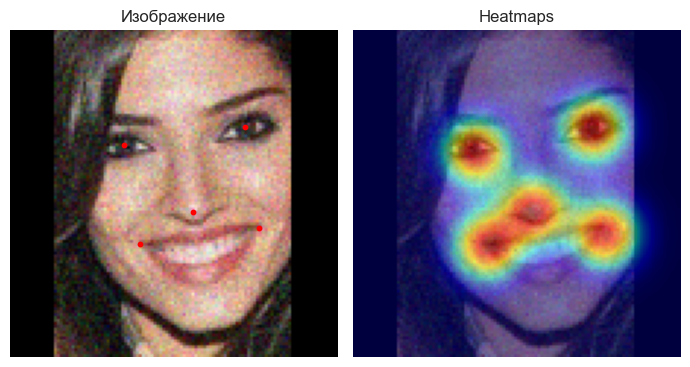

In [569]:
# визуализируем результат

sample = train_dataset[2]

# денормализуем изображение (обратно к [0, 1])
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = sample['image'].permute(1, 2, 0).cpu().numpy()
image = image * std + mean
image = np.clip(image, 0, 1)

heatmaps = sample['heatmaps'].permute(1, 2, 0).cpu().numpy() # переставляем измерения, чтобы далее ресайз прошел нормально
heatmaps_resized = cv2.resize(heatmaps, IMAGE_SIZE, interpolation=cv2.INTER_CUBIC)
combined_heatmap = np.sum(heatmaps_resized, axis=2) # суммируем все heatmaps

landmarks = sample['landmarks'].cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(7, 5))
# визуализируем изображение
axes[0].imshow(image)
axes[0].set_title('Изображение')
# накладываем на него landmarks с пересчитанными координатами (проверяем визуально)
for i, landmark in enumerate(landmarks):
    axes[0].scatter(landmark[0], landmark[1], c='red', s=10)
axes[0].axis('off')

# визуализируем heatmaps
axes[1].imshow(combined_heatmap, cmap='jet', alpha=1)
axes[1].imshow(image, alpha=0.5)
axes[1].set_title('Heatmaps')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Модель Stacked Hourglass для распознавания ключевых точек лица

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)


class Hourglass(nn.Module):
    def __init__(self, depth, f, increase=0):
        """
        depth: глубина hourglass (≥1)
        f: число каналов
        increase: увелечение числа каналов на глубине
        """
        super().__init__()
        self.depth = depth
        nf = f + increase

        self.up1 = ResidualBlock(f, f)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.low1 = ResidualBlock(f, nf)

        # Рекурсия
        if depth > 1:
            self.low2 = Hourglass(depth - 1, nf, increase)
        else:
            self.low2 = ResidualBlock(nf, nf)

        self.low3 = ResidualBlock(nf, f)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        up1 = self.up1(x)
        pool1 = self.pool1(x)
        low1 = self.low1(pool1)
        low2 = self.low2(low1)
        low3 = self.low3(low2)
        up2 = self.up2(low3)
        
        # Приводим up2 к размерам up1 если необходимо
        if up1.size(2) != up2.size(2) or up1.size(3) != up2.size(3):
            up2 = F.interpolate(up2, size=(up1.size(2), up1.size(3)), mode='nearest')
            
        return up1 + up2


class Merge(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.conv = nn.Conv2d(x_dim, y_dim, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(y_dim)

    def forward(self, x):
        return self.bn(self.conv(x))


class HeatmapLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, gt):
        return ((pred - gt) ** 2).mean()


class StackedHourglass(nn.Module):
    def __init__(self, nstack=2, inp_dim=128, oup_dim=5, increase=0):
        super().__init__()
        """
        Args:
            nstack: число HourGlass блоков
            inp_dim: число входных каналов
            oup_dim: число выходных каналов (число keypoints)
            increase: увелечение числа каналов на глубине
        """

        self.nstack = nstack
        self.increase = increase
        self.oup_dim = oup_dim
        
        # пПредобработка
        self.pre = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(128, 128),
            ResidualBlock(128, inp_dim)
        )

        # Hourglass стеки
        self.hgs = nn.ModuleList([
            Hourglass(depth=3, f=inp_dim, increase=increase)
            for _ in range(nstack)
        ])

        # слои обработки признаков
        self.features = nn.ModuleList([
            nn.Sequential(
                ResidualBlock(inp_dim, inp_dim),
                nn.Conv2d(inp_dim, inp_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(inp_dim),
                nn.ReLU(inplace=True)
            ) for _ in range(nstack)
        ])

        # слои предсказания heatmap'ов
        self.outs = nn.ModuleList([
            nn.Conv2d(inp_dim, oup_dim, kernel_size=1)
            for _ in range(nstack)
        ])
        
        # слои объединения для skip-соединений
        self.merge_features = nn.ModuleList([
            Merge(inp_dim, inp_dim) for _ in range(nstack-1)
        ])
        self.merge_preds = nn.ModuleList([
            Merge(oup_dim, inp_dim) for _ in range(nstack-1)
        ])
        
        # Loss функция - простой MSE
        self.heatmap_loss = HeatmapLoss()


    def forward(self, x):
        x = self.pre(x)  # [batch, inp_dim, 28, 28]
        combined_hm_preds = []
        
        for i in range(self.nstack):
            hg = self.hgs[i](x)  # [batch, inp_dim, 28, 28]
            feature = self.features[i](hg)  # [batch, inp_dim, 28, 28]
            preds = self.outs[i](feature)  # [batch, oup_dim, 28, 28]
            combined_hm_preds.append(preds)
            
            if i < self.nstack - 1:
                x = x + self.merge_preds[i](preds) + self.merge_features[i](feature)
        
        # возвращаем стеки как [batch, nstack, oup_dim, 28, 28]
        return torch.stack(combined_hm_preds, dim=1)


    def calc_loss(self, outputs, targets):
        """
        Подсчет функции потерь
        
        Args:
            outputs: [batch, nstack, 5, 28, 28]
            targets: [batch, 5, 28, 28]
        """
        total_loss = 0.0
        nstacks = outputs.size(1)
        
        for i in range(nstacks):
            pred = outputs[:, i]  # [batch, 5, 28, 28]
            total_loss += self.heatmap_loss(pred, targets)
            
        return total_loss / nstacks


    def predict_landmarks(self, heatmaps):
        """
        Функция преобразования heatmap -> координаты
        
        Args:
            heatmaps: [batch, 5, 28, 28] - предсказанные heatmap'ы
            
        Returns:
            landmarks: [batch, 5, 2] - координаты в системе 112x112
        """
        batch_size, num_landmarks, h, w = heatmaps.shape
        landmarks = torch.zeros((batch_size, num_landmarks, 2), device=heatmaps.device)
        
        for b in range(batch_size):
            for i in range(num_landmarks):
                hm = heatmaps[b, i]
                
                # Находим координаты максимума (hard argmax) - более стабильно для начальной стадии
                max_idx = torch.argmax(hm)
                y_hm = max_idx // w
                x_hm = max_idx % w
                
                # пересчет координат: heatmap 28x28 -> изображение 112x112
                x_img = x_hm * (112.0 / 28.0)
                y_img = y_hm * (112.0 / 28.0)
                
                landmarks[b, i, 0] = x_img
                landmarks[b, i, 1] = y_img
        
        return landmarks

### Проверка готовности GPU 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    #gc.collect()
    #torch.cuda.empty_cache()
    pass

print(f"PyTorch версия: {torch.__version__}")
print(f"CUDA доступна: {torch.cuda.is_available()}")
print(f"Версия CUDA: {torch.version.cuda}")
print(f"Количество GPU: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Текущее устройство: {torch.cuda.current_device()}")
    print(f"Имя устройства: {torch.cuda.get_device_name(0)}")
    print(f"Память: {torch.cuda.mem_get_info()[0]/1024**3:.2f} GB свободно из {torch.cuda.mem_get_info()[1]/1024**3:.2f} GB")

    # Проверка простой операции на GPU
    try:
        test_tensor = torch.randn(100, 100).to(device)
        print("Тестовый тензор на GPU создан успешно")
    except Exception as e:
        print(f"Ошибка при создании тензора: {e}")

PyTorch версия: 2.5.1
CUDA доступна: True
Версия CUDA: 12.1
Количество GPU: 1
Текущее устройство: 0
Имя устройства: NVIDIA GeForce RTX 2060
Память: 5.47 GB свободно из 5.79 GB
Тестовый тензор на GPU создан успешно


### Обучение модели Stacked Hourglass

In [573]:
# Визуализация предсказаний в процессе обучения

def visualize_predictions(model, dataloader, num_images=5, dir_save_images='', device='cuda', epoch=0, show_inline=False):
    """
    Визуализация предсказаний на преобразованных изображениях (тех, на которых учится модель)
    
    Args:
        model: обученная модель
        dataloader: даталоадер для валидации
        num_images: количество изображений для визуализации
        device: устройство ('cuda' или 'cpu')
        epoch: номер текущей эпохи
        show_inline: отображать ли изображение в ноутбуке
        clear_previous: очищать ли предыдущую визуализацию
    """
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    if num_images == 1:
        axes = [axes]
    
    # Параметры денормализации
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    processed = 0
    with torch.no_grad():
        for batch in dataloader:
            if processed >= num_images:
                break
                
            images = batch['image'].to(device)  # Уже преобразованные изображения 112x112
            img_ids = batch['image_id']
            
            # Предсказание heatmap'ов
            outputs = model(images)
            heatmaps = outputs if outputs.dim() == 4 else outputs[:, -1]  # берем последний стек
            landmarks = model.predict_landmarks(heatmaps).cpu().numpy()
            
            # Визуализация для каждого изображения в батче
            for i in range(min(len(images), num_images - processed)):
                if processed >= num_images:
                    break
                
                # Денормализация изображения для визуализации
                img = images[i].cpu().numpy().transpose(1, 2, 0)
                img = img * std + mean
                img = np.clip(img, 0, 1)
                
                # Визуализация
                ax = axes[processed]
                ax.imshow(img)
                ax.scatter(landmarks[i, :, 0], landmarks[i, :, 1], c='red', s=30, marker='x')
                
                # Подписываем точки для идентификации
                for j, (x, y) in enumerate(landmarks[i]):
                    ax.text(x + 2, y + 2, str(j), color='white', fontsize=6,
                           bbox=dict(facecolor='blue', alpha=0.5))
                
                ax.set_title(f'ID: {img_ids[i]}')
                ax.axis('off')
                
                processed += 1
    
    plt.tight_layout()
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(dir_save_images, f'predictions_epoch_{epoch}_{timestamp}.png')
    plt.savefig(output_path, bbox_inches='tight', dpi=100)
    
    # Отображение в ноутбуке
    if show_inline:
        plt.show(fig)  # отображаем текущую фигуру
    
    plt.close(fig)
    model.train()
    print(f"Визуализация на изображениях батча сохранена как '{output_path}'")
    return output_path

In [574]:
# Функция для расчета NME (Normalized Mean Error)
def calculate_nme(pred_landmarks, gt_landmarks):
    """
    Расчет NME в процентах
    pred_landmarks, gt_landmarks: [batch_size, 5, 2]
    """
    with torch.no_grad():
        # Расстояние между глазами для нормализации
        left_eye_gt = gt_landmarks[:, 0]   # левый глаз (индекс 0)
        right_eye_gt = gt_landmarks[:, 1]  # правый глаз (индекс 1)
        eye_dist = torch.norm(left_eye_gt - right_eye_gt, dim=1)  # [batch_size]
        
        # Ошибка для каждой точки
        errors = torch.norm(pred_landmarks - gt_landmarks, dim=2)  # [batch_size, 5]
        mean_errors = torch.mean(errors, dim=1)  # [batch_size]
        
        # NME в процентах
        nme = torch.mean(mean_errors / eye_dist) * 100
        return nme.item()

In [ ]:
# Инициализация модели и оптимизатора
model_shg = StackedHourglass(nstack=2, inp_dim=128, oup_dim=5, increase=0).to(device)

optimizer_shg = optim.AdamW(model_shg.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_shg, mode='min', patience=7, factor=0.5, min_lr=1e-6, verbose=True)


best_val_loss = float('inf') # начальный лосс
best_val_nme = float('inf') # лучший NME

# Создаем папку для сохранения моделей
os.makedirs('checkpoints', exist_ok=True)


# списки для хранения лоссов (при дообучении - след.ячейка - будут накапливаться!)
train_losses = []
val_losses = []
val_nmes = []  # для сбора NME на валидации
lrs = []       # для сбора learning rate

# переменные для хранения путей к файлам весов лучших моделей
state_file_best_nme = ''
state_file_best_loss = ''

Эпоха 61/80 [Train]:   0%|          | 0/121 [00:00<?, ?it/s]

Эпоха 61/80 [Validate]: 100%|██████████| 26/26 [00:28<00:00,  1.09s/it, loss=0.0004, nme=5.69%]


Эпоха 61/80, Время: 198.8с,  Train Loss: 0.0003, Val Loss: 0.0004,  Val NME: 5.64%, LR: 0.000100
Сохранена лучшая модель по NME: checkpoints/best_model_nme_20260123_232520_epoch_61_nme_5.64.pt


Эпоха 62/80 [Validate]: 100%|██████████| 26/26 [00:28<00:00,  1.08s/it, loss=0.0004, nme=5.64%]


Эпоха 62/80, Время: 198.6с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.64%, LR: 0.000100
Сохранена лучшая модель по NME: checkpoints/best_model_nme_20260123_232839_epoch_62_nme_5.64.pt


Эпоха 63/80 [Validate]: 100%|██████████| 26/26 [00:29<00:00,  1.13s/it, loss=0.0004, nme=5.65%]


Эпоха 63/80, Время: 189.0с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.63%, LR: 0.000100
Сохранена лучшая модель по NME: checkpoints/best_model_nme_20260123_233148_epoch_63_nme_5.63.pt


Эпоха 64/80 [Validate]: 100%|██████████| 26/26 [00:29<00:00,  1.15s/it, loss=0.0004, nme=5.64%]


Эпоха 64/80, Время: 197.6с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.60%, LR: 0.000100
Сохранена лучшая модель по NME: checkpoints/best_model_nme_20260123_233506_epoch_64_nme_5.60.pt


Эпоха 65/80 [Validate]: 100%|██████████| 26/26 [00:30<00:00,  1.18s/it, loss=0.0004, nme=5.64%]


Эпоха 65/80, Время: 210.3с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.64%, LR: 0.000100


Эпоха 66/80 [Validate]: 100%|██████████| 26/26 [00:32<00:00,  1.25s/it, loss=0.0004, nme=5.73%]


Эпоха 66/80, Время: 199.0с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.64%, LR: 0.000100


Эпоха 67/80 [Validate]: 100%|██████████| 26/26 [00:29<00:00,  1.15s/it, loss=0.0004, nme=5.67%]


Эпоха 67/80, Время: 195.7с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.63%, LR: 0.000100


Эпоха 68/80 [Validate]: 100%|██████████| 26/26 [00:31<00:00,  1.20s/it, loss=0.0004, nme=5.60%]


Эпоха 68/80, Время: 198.2с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.67%, LR: 0.000100


Эпоха 69/80 [Validate]: 100%|██████████| 26/26 [00:33<00:00,  1.30s/it, loss=0.0004, nme=5.68%]


Эпоха 69/80, Время: 206.2с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.63%, LR: 0.000100


Эпоха 70/80 [Validate]: 100%|██████████| 26/26 [00:34<00:00,  1.33s/it, loss=0.0004, nme=5.65%]


Эпоха 70/80, Время: 208.9с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.68%, LR: 0.000100


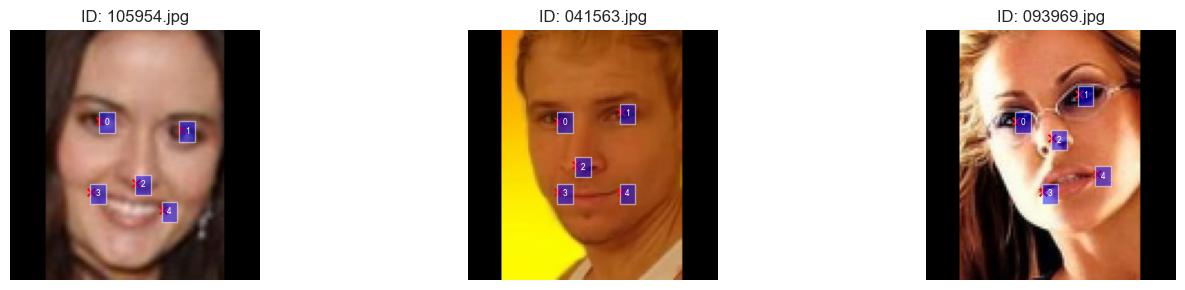

Визуализация на изображениях батча сохранена как 'checkpoints/predictions_epoch_70_20260123_235527.png'


Эпоха 71/80 [Validate]: 100%|██████████| 26/26 [00:45<00:00,  1.74s/it, loss=0.0004, nme=5.64%]


Эпоха 71/80, Время: 271.8с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.69%, LR: 0.000100


Эпоха 72/80 [Validate]: 100%|██████████| 26/26 [00:43<00:00,  1.69s/it, loss=0.0004, nme=5.61%]


Эпоха 72/80, Время: 286.1с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.61%, LR: 0.000050


Эпоха 73/80 [Validate]: 100%|██████████| 26/26 [00:44<00:00,  1.72s/it, loss=0.0004, nme=5.69%]


Эпоха 73/80, Время: 286.4с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.66%, LR: 0.000050


Эпоха 74/80 [Validate]: 100%|██████████| 26/26 [00:35<00:00,  1.38s/it, loss=0.0004, nme=5.62%]


Эпоха 74/80, Время: 242.7с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.75%, LR: 0.000050


Эпоха 75/80 [Validate]: 100%|██████████| 26/26 [00:30<00:00,  1.18s/it, loss=0.0004, nme=5.66%]


Эпоха 75/80, Время: 235.3с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.73%, LR: 0.000050


Эпоха 76/80 [Validate]: 100%|██████████| 26/26 [00:36<00:00,  1.42s/it, loss=0.0004, nme=5.66%]


Эпоха 76/80, Время: 221.3с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.70%, LR: 0.000050


Эпоха 77/80 [Validate]: 100%|██████████| 26/26 [00:35<00:00,  1.37s/it, loss=0.0004, nme=5.62%]


Эпоха 77/80, Время: 222.4с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.68%, LR: 0.000050


Эпоха 78/80 [Validate]: 100%|██████████| 26/26 [00:32<00:00,  1.24s/it, loss=0.0004, nme=5.67%]


Эпоха 78/80, Время: 227.1с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.66%, LR: 0.000050


Эпоха 79/80 [Validate]: 100%|██████████| 26/26 [00:42<00:00,  1.64s/it, loss=0.0004, nme=5.63%]


Эпоха 79/80, Время: 261.5с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.64%, LR: 0.000050


Эпоха 80/80 [Validate]: 100%|██████████| 26/26 [00:34<00:00,  1.33s/it, loss=0.0004, nme=5.65%]


Эпоха 80/80, Время: 253.2с,  Train Loss: 0.0003, Val Loss: 0.0003,  Val NME: 5.73%, LR: 0.000050


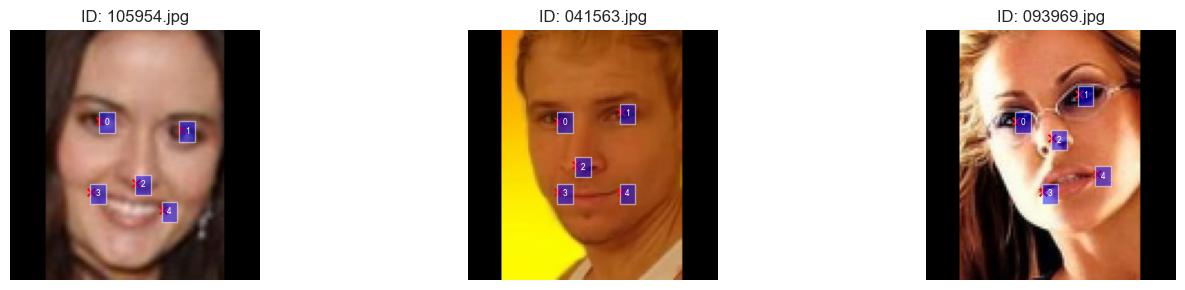

Визуализация на изображениях батча сохранена как 'checkpoints/predictions_epoch_80_20260124_003720.png'

Обучение завершено!
Лучший NME: 5.60%
Лучший loss: 0.0003


In [ ]:
# обучение/дообучение модели


# пробуем дообучить еще на 20 эпохах лучшую модель (которую загружаем далее после обучения на 40-60 эпохах)
if len(train_losses) > 40: # дообучаем если ранее уже обучали хотя бы на 40 эпохах
    # меняем learning rate
    optimizer_shg = torch.optim.AdamW(model_shg.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_shg, 'min', patience=5, factor=0.5, min_lr=1e-6, verbose=True)



num_epochs = 20


start_epoch = len(train_losses)

for epoch in range(start_epoch, start_epoch + num_epochs):
    epoch_start_time = time.time()
    
    # Обучение
    model_shg.train()
    epoch_loss = 0.0
    
    pbar_train = tqdm(train_loader, desc=f'Эпоха {epoch+1}/{start_epoch + num_epochs} [Train]')
    for batch in pbar_train:
        images = batch['image'].to(device)
        targets = batch['heatmaps'].to(device)
        
        optimizer_shg.zero_grad()
        outputs = model_shg(images)
        loss = model_shg.calc_loss(outputs, targets)
        
        loss.backward()
        optimizer_shg.step()
        
        epoch_loss += loss.item()
        pbar_train.set_postfix(loss=f'{loss.item():.4f}')
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Валидация
    model_shg.eval()
    val_loss = 0.0
    total_nme = 0.0
    nme_count = 0
    
    with torch.no_grad():
        pbar_val = tqdm(val_loader, desc=f'Эпоха {epoch+1}/{start_epoch + num_epochs} [Validate]')
        for batch in pbar_val:
            images = batch['image'].to(device)
            targets = batch['heatmaps'].to(device)
            gt_landmarks = batch['landmarks'].to(device)  # ground truth координаты
            
            outputs = model_shg(images)
            loss = model_shg.calc_loss(outputs, targets)
            val_loss += loss.item()
            
            # Рассчитываем NME только для последнего стека
            if outputs.dim() == 5:  # [batch, nstack, 5, 28, 28]
                final_heatmaps = outputs[:, -1]  # последний стек
            else:
                final_heatmaps = outputs
            
            # Предсказываем координаты
            pred_landmarks = model_shg.predict_landmarks(final_heatmaps)  # [batch, 5, 2]
            
            # Считаем NME
            batch_nme = calculate_nme(pred_landmarks, gt_landmarks)
            total_nme += batch_nme * len(images)
            nme_count += len(images)
            
            pbar_val.set_postfix(loss=f'{loss.item():.4f}', nme=f'{batch_nme:.2f}%')
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_nme = total_nme / nme_count if nme_count > 0 else float('inf')
    
    val_losses.append(avg_val_loss)
    val_nmes.append(avg_val_nme)
    
    # Получаем текущий learning rate
    current_lr = optimizer_shg.param_groups[0]['lr']
    # Обновляем список LR
    lrs.append(current_lr)
    
    scheduler.step(avg_val_loss)
    
    prev_lr = lrs[-1] if lrs else current_lr  # предыдущий LR из истории
    # Если LR изменился - выводим сообщение
    if abs(current_lr - prev_lr) > 1e-8:
        print(f"Learning rate изменен: {prev_lr:.6f} -> {current_lr:.6f}")    
       

    epoch_time = time.time() - epoch_start_time
    print(f'Эпоха {epoch+1}/{start_epoch+num_epochs}, Время: {epoch_time:.1f}с,  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f},  Val NME: {avg_val_nme:.2f}%, LR: {current_lr:.6f}')
    
    # Визуализация каждые ___ эпох
    if (epoch + 1) % 10 == 0:
        try:
            visualize_predictions(
                model_shg, 
                val_loader, 
                num_images=3,
                dir_save_images='checkpoints',
                device=device,
                epoch=epoch + 1,
                show_inline=True
            )
        except Exception as e:
            print(f"Ошибка при визуализации: {e} \nПродолжаем обучение без визуализации...")
    
    # Сохраняем лучшие веса по NME
    if avg_val_nme < best_val_nme:
        best_val_nme = avg_val_nme
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        checkpoint_path = f'checkpoints/best_model_nme_{timestamp}_epoch_{epoch+1}_nme_{best_val_nme:.2f}.pt'
        state_file_best_nme = checkpoint_path
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model_shg.state_dict(),
            'optimizer_state_dict': optimizer_shg.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_nme': avg_val_nme,
            'best_val_nme': best_val_nme,
            'lr': current_lr
        }, checkpoint_path)
        
        print(f'Сохранена лучшая модель по NME: {checkpoint_path}')
    
    # Сохраняем лучшие веса по loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        checkpoint_path = f'checkpoints/best_model_loss_{timestamp}_epoch_{epoch+1}_loss_{best_val_loss:.4f}.pt'
        state_file_best_loss = checkpoint_path

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model_shg.state_dict(),
            'optimizer_state_dict': optimizer_shg.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_nme': avg_val_nme,
            'best_val_loss': best_val_loss,
            'lr': current_lr
        }, checkpoint_path)

        print(f'Сохранена лучшая модель по Loss: {checkpoint_path}')

# Сохраняем финальное состояние модели и метрик
torch.save({
    'model_state_dict': model_shg.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_nmes': val_nmes,
    'lrs': lrs,
    'best_val_nme': best_val_nme,
    'best_val_loss': best_val_loss,
    'final_epoch': num_epochs
}, 'checkpoints/final_model_with_metrics.pt')

print("\nОбучение завершено!")
print(f"Лучший NME: {best_val_nme:.2f}%")
print(f"Лучший loss: {best_val_loss:.4f}")

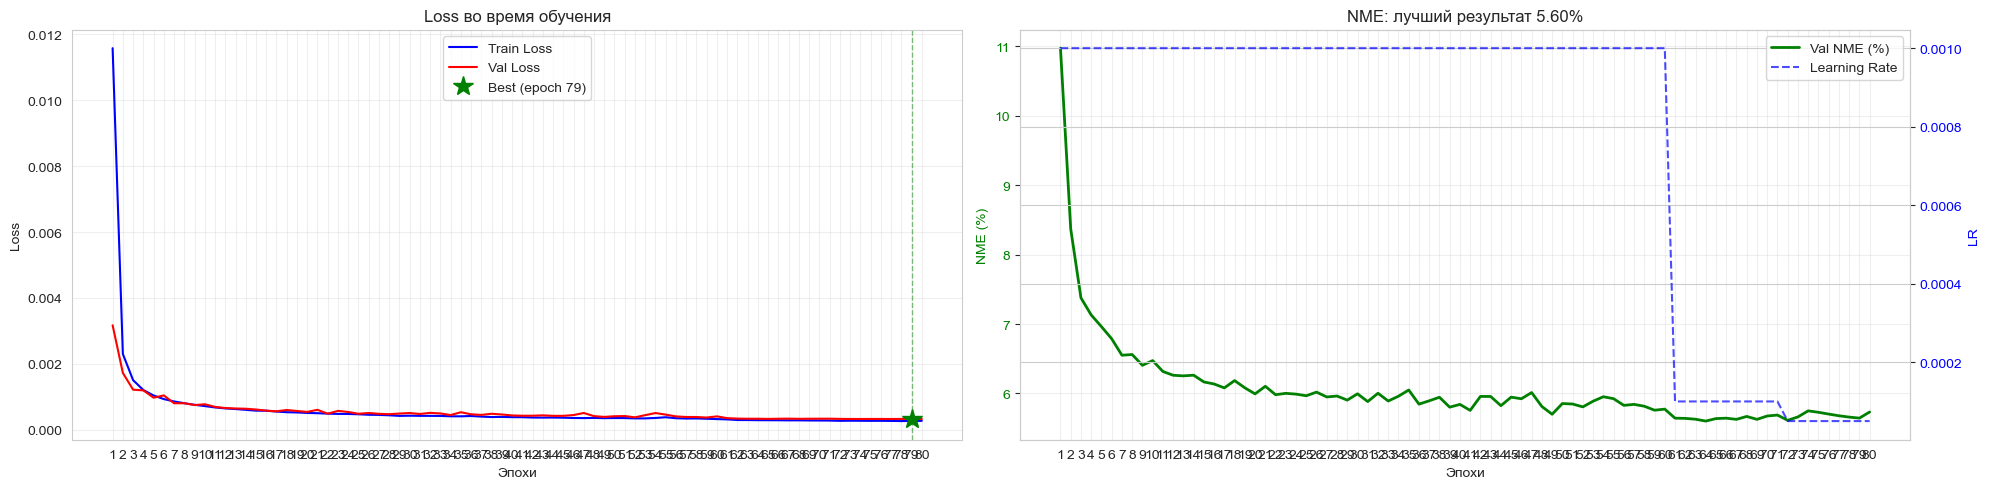


Итоговые метрики обучения:
Лучший NME: 5.60%
Финальный NME: 5.73%
Лучший loss: 0.0003
Финальный loss: 0.0003
Последний learning rate: 0.000050


In [601]:
# Визуализация результатов обучения

plt.figure(figsize=(20, 5))

# ось эпох для графиков (для лучшего визуального восприятия)
epochs = list(range(1, len(train_losses) + 1))

best_epoch = np.argmin(val_losses) + 1
best_loss = val_losses[best_epoch - 1]


# Loss
ax = plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Val Loss')
plt.xticks(epochs)

# отмечаем лучшую эпоху и лучший loss
ax.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, linewidth=1)
ax.plot(best_epoch, best_loss, 'g*', markersize=15, label=f'Best (epoch {best_epoch})')

plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('Loss во время обучения')
plt.legend()
plt.grid(alpha=0.3)

# NME и Learning Rate
plt.subplot(1, 2, 2)
line_nme, = plt.plot(epochs, val_nmes, 'g-', label='Val NME (%)', linewidth=2)
plt.xlabel('Эпохи')
plt.ylabel('NME (%)', color='g')
plt.tick_params(axis='y', labelcolor='g')
plt.title(f'NME: лучший результат {best_val_nme:.2f}%')
plt.grid(alpha=0.3)

# learning rate на второй оси
ax2 = plt.gca().twinx()
line_lr, = ax2.plot(epochs, lrs, 'b--', label='Learning Rate', alpha=0.7)
ax2.set_ylabel('LR', color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.xticks(epochs)

lines = [line_nme, line_lr]
labels = [line.get_label() for line in lines]
# Создаем единую легенду для всего графика
plt.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nИтоговые метрики обучения:")
print(f"Лучший NME: {best_val_nme:.2f}%")
print(f"Финальный NME: {val_nmes[-1]:.2f}%")
print(f"Лучший loss: {best_val_loss:.4f}")
print(f"Финальный loss: {val_losses[-1]:.4f}")
print(f"Последний learning rate: {lrs[-1]:.6f}")

### Создание датасета выровненных изображений (aligned images)

__Загружаем модель с лучшей метрикой по NME__

In [618]:
print(f"Лучшая модель по NME: {state_file_best_nme}")
print(f"Лучшая модель по Loss: {state_file_best_loss}")

Лучшая модель по NME: checkpoints/best_model_nme_20260123_233506_epoch_64_nme_5.60.pt
Лучшая модель по Loss: checkpoints/best_model_loss_20260124_003303_epoch_79_loss_0.0003.pt


In [626]:
best_model_path = state_file_best_nme

#best_model_path = state_file_best_loss


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# инициализация модели с такими же параметрами, как при обучении
model_shg = StackedHourglass(nstack=2, inp_dim=128, oup_dim=5).to(device)

# загружаем веса
checkpoint = torch.load(best_model_path, map_location=device, weights_only=True)
model_shg.load_state_dict(checkpoint['model_state_dict'])

# переводим в режим инференса
model_shg.eval()

print(f"Модель загружена из: {best_model_path}")
if 'best_val_nme' in checkpoint:
    print(f"Лучший NME: {checkpoint['best_val_nme']:.2f}%")
if 'best_val_loss' in checkpoint:
    print(f"Лучший Loss: {checkpoint['best_val_loss']:.2f}%")
print(f"Эпоха: {checkpoint['epoch']}")

Модель загружена из: checkpoints/best_model_nme_20260123_233506_epoch_64_nme_5.60.pt
Лучший NME: 5.60%
Эпоха: 64


__Формируем датасет выровненных изображений__

In [611]:
# формирование шаблона ключевых точек как усреднение предсказанных точек в датасете

def create_template_from_predictions(dataset, model, device):
    """Создает шаблон на основе предсказанных точек"""
    all_landmarks = []
    
    for i in tqdm(range(len(dataset)), desc="Создание шаблона"):
        sample = dataset[i]
        img_tensor = sample['image'].unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(img_tensor)
            heatmaps = outputs[:, -1] if outputs.dim() == 5 else outputs
            pred_landmarks = model.predict_landmarks(heatmaps).cpu().numpy()[0]
            all_landmarks.append(pred_landmarks)
        
    return mean_landmarks


CUSTOM_TEMPLATE_LM = create_template_from_predictions(train_dataset, model_shg, device)

Создание шаблона: 100%|██████████| 7700/7700 [04:03<00:00, 31.60it/s]


In [637]:
def denormalize_image(tensor):
    """Денормализация тензора изображения [3, H, W] в numpy [H, W, 3] в диапазоне [0-255]"""
    img = tensor.permute(1, 2, 0).cpu().numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = img * std + mean
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img


def align_face(cropped_face, predicted_landmarks, output_size=(112, 112), ideal_landmarks=STANDARD_LANDMARKS):
    """
    Корректное выравнивание с учетом системы координат CelebA
    
    Args:
        cropped_face: обрезанное изображение лица [H, W, 3] в RGB
        predicted_landmarks: предсказанные координаты [5, 2] в системе 112x112
        output_size: размер выходного изображения
        ideal_landmarks: идеальные координаты для выравнивания [5, 2] в системе 112x112
    """
    # Получаем размеры исходного обрезанного изображения
    h, w = cropped_face.shape[:2]
    assert h == 112 and w == 112, f"Ожидаемое изображение 112x112, получено {w}x{h}"    
            
    # вычисляем аффинное преобразование (используем только 3 точки для более стабильного выравнивания (глаза и нос))
    src_points = predicted_landmarks[:3].astype(np.float32)
    dst_points = ideal_landmarks[:3].astype(np.float32)   
    M = cv2.estimateAffinePartial2D(src_points, dst_points, confidence=0.99)[0]
    
    if M is None:
        # если не удалось вычислить аффинное преобразование
        M = np.eye(2, 3, dtype=np.float32)
    
    # применяем преобразование
    aligned_face = cv2.warpAffine(
        cropped_face,
        M,
        output_size,
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0
    )
    
    # вычисляем выровненные landmarks
    aligned_landmarks = np.zeros_like(ideal_landmarks)
    for j in range(len(ideal_landmarks)):
        x, y = ideal_landmarks[j]
        aligned_landmarks[j] = np.dot(M, np.array([x, y, 1]))
    
    return aligned_face, aligned_landmarks


def process_dataset_for_alignment(dataset, dataset_name, aligned_dir=None, ideal_landmarks=STANDARD_LANDMARKS):
    """
    Обработка датасета для создания выровненных изображений и сохранение выровненных изображений в папку
    """
    if aligned_dir is None:
        print(f"Ошибка, параметр 'aligned_dir' должен быть указан! Обработка прервана!")
        return None

    if not os.path.exists(aligned_dir):
        os.makedirs(aligned_dir)    

    aligned_data = []
        
    for idx in tqdm(range(len(dataset)), desc=f'Обработка {dataset_name}'):
        # получаем подготовленный пример из датасета
        sample = dataset[idx]
        # извлекаем из текущего примера изображение для модели (уже обрезано по bbox и нормализовано)
        input_tensor = sample['image'].unsqueeze(0).to(device)  # [1, 3, 112, 112]
        # денормализуем изображение для выравнивания
        cropped_face = denormalize_image(sample['image'])  # [H, W, 3] в RGB, [0-255]
        
        # предсказываем landmarks
        with torch.no_grad():
            outputs = model_shg(input_tensor)
            heatmaps = outputs[:, -1] if outputs.dim() == 5 else outputs
            pred_landmarks = model_shg.predict_landmarks(heatmaps).cpu().numpy()[0]  # [5, 2]
        
        # выравниваем лицо
        aligned_face, aligned_landmarks = align_face(cropped_face, pred_landmarks, ideal_landmarks=ideal_landmarks)
        
        # сохраняем выровненное изображение
        original_id = sample['image_id']
        aligned_id = f"{os.path.splitext(original_id)[0]}_aligned.jpg"
        #aligned_path = os.path.join(aligned_dir, aligned_id)
        aligned_path = os.path.join(aligned_dir, original_id)
        
        # CV2 ожидает BGR формат
        aligned_face_bgr = cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR)
        success = cv2.imwrite(aligned_path, aligned_face_bgr)
        
        if not success:
            print(f"Ошибка сохранения изображения: {aligned_path}")
            continue
        
        # Сохраняем метаданные
        aligned_data.append({
            'aligned_id': aligned_id,
            'original_id': original_id,
            'image_path': aligned_path,
            'dataset': dataset_name,
            'landmarks_pred': pred_landmarks.tolist(),
            'landmarks_aligned': aligned_landmarks.tolist(),
            'landmarks_ideal': ideal_landmarks.tolist()
        })
        
    return aligned_data

In [ ]:
# стандартные координаты для 112x112 (CelebA формат)
STANDARD_LANDMARKS = np.array([
    [38.2946, 51.6963],  # левый глаз
    [73.5318, 51.5014],  # правый глаз  
    [56.0252, 71.7366],  # нос
    [41.5493, 92.3655],  # левый угол рта
    [70.7291, 92.2041]   # правый угол рта
])


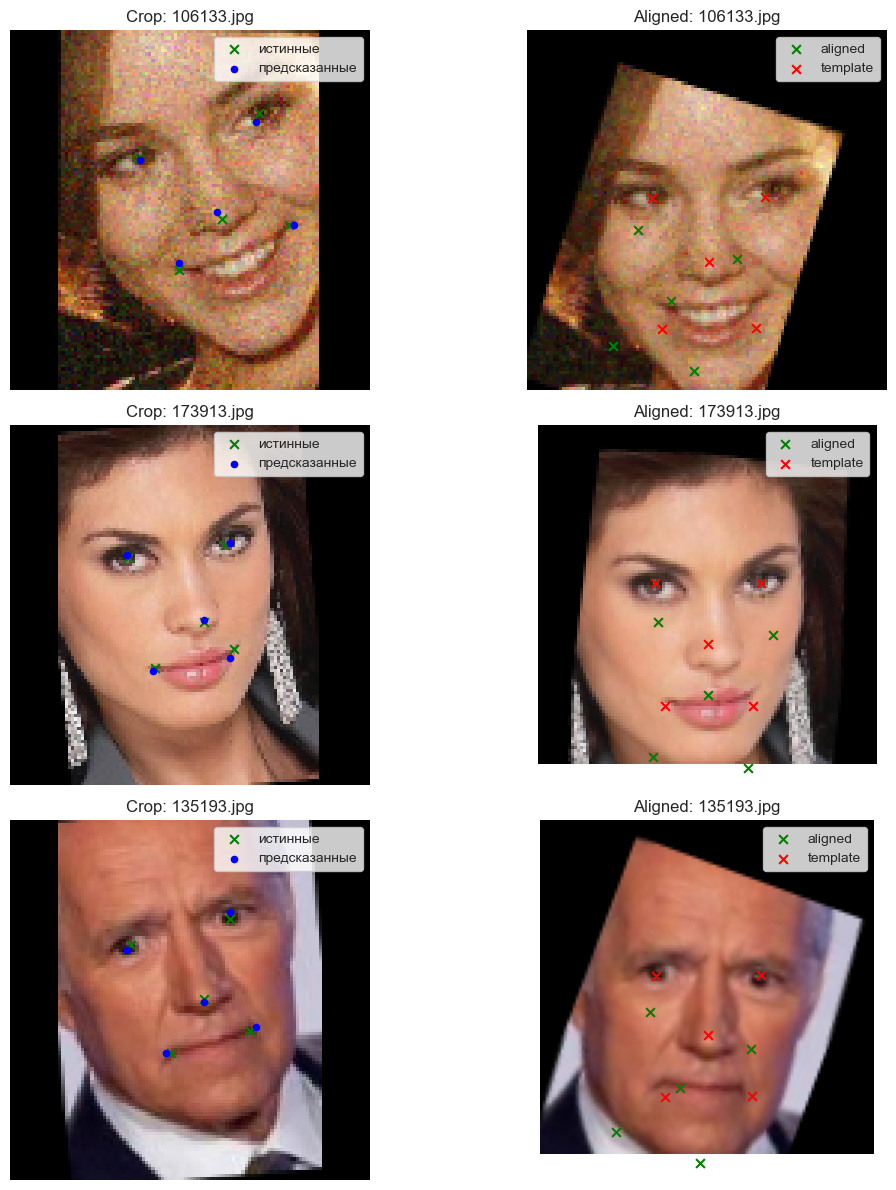

In [638]:
# Визуализируем несколько примеров "на лету"
indices = random.sample(range(len(train_dataset)), 3)
plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    sample = train_dataset[idx]
    img_tensor = sample['image']
    img_id = sample['image_id']
    
    # Денормализуем изображение
    img_denorm = denormalize_image(img_tensor)
    
    # Получаем предсказанные landmarks
    model_shg.eval()
    with torch.no_grad():
        outputs = model_shg(img_tensor.unsqueeze(0).to(device))
        heatmaps = outputs[:, -1] if outputs.dim() == 5 else outputs
        pred_landmarks = model_shg.predict_landmarks(heatmaps).cpu().numpy()[0]
    
    # Выравниваем лицо
    aligned_face, aligned_landmarks = align_face(
        img_denorm, 
        pred_landmarks, 
        ideal_landmarks=STANDARD_LANDMARKS
    )
    
    # Сохраняем выровненное изображение
    #aligned_id = f"{os.path.splitext(img_id)[0]}_aligned.jpg"
    aligned_id = img_id
    aligned_path = os.path.join(dir_aligned_mini, aligned_id)
    cv2.imwrite(aligned_path, cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR))
    
    # Визуализация
    plt.subplot(3, 2, i*2+1)
    plt.imshow(img_denorm)
    plt.scatter(sample['landmarks'][:, 0], sample['landmarks'][:, 1], c='green', s=40, marker='x', label='истинные') 
    plt.scatter(pred_landmarks[:, 0], pred_landmarks[:, 1], c='blue', s=20, marker='o', label='предсказанные')
    plt.title(f'Crop: {img_id}')
    plt.legend()
    plt.axis('off')
    
    plt.subplot(3, 2, i*2+2)
    plt.imshow(aligned_face)
    plt.scatter(aligned_landmarks[:, 0], aligned_landmarks[:, 1], c='green', s=40, marker='x', label='aligned')
    plt.scatter(STANDARD_LANDMARKS[:, 0], STANDARD_LANDMARKS[:, 1], c='red', s=40, marker='x', label='template')
    plt.title(f'Aligned: {img_id}')
    plt.legend()
    plt.axis('off')

plt.tight_layout()
plt.savefig('correct_alignment.png', bbox_inches='tight', dpi=100)
plt.show()

Если выравнивание удовлетворительное, но выравниваем весь датасет.

Функция process_dataset_for_aligment сохраняет выровненные изображения в указанную папку и возвращает метаданные выровненных изображений (список значений параметров)

In [639]:
# обрабатываем все части датасета
train_aligned = process_dataset_for_alignment(train_dataset, 'train', aligned_dir=dir_aligned_mini, ideal_landmarks=STANDARD_LANDMARKS)
val_aligned = process_dataset_for_alignment(val_dataset, 'val', aligned_dir=dir_aligned_mini, ideal_landmarks=STANDARD_LANDMARKS)
test_aligned = process_dataset_for_alignment(test_dataset, 'test', aligned_dir=dir_aligned_mini, ideal_landmarks=STANDARD_LANDMARKS)

# переводим возвращенные параметры выровненных изображений в датафреймы
train_aligned_df = pd.DataFrame(train_aligned)
val_aligned_df = pd.DataFrame(val_aligned)
test_aligned_df = pd.DataFrame(test_aligned)

# сохраняем метаданные датасетов выровненных изображений в соответствующие файлы
train_aligned_df.to_csv(f'{dir_dataset_mini}/train_aligned_mini.csv', index=False)
val_aligned_df.to_csv(f'{dir_dataset_mini}/val_aligned_mini.csv', index=False)
test_aligned_df.to_csv(f'{dir_dataset_mini}/test_aligned_mini.csv', index=False)


Обработка test: 100%|██████████| 1650/1650 [00:46<00:00, 35.25it/s]


Дополнительно проверяем выравнивание в датасете

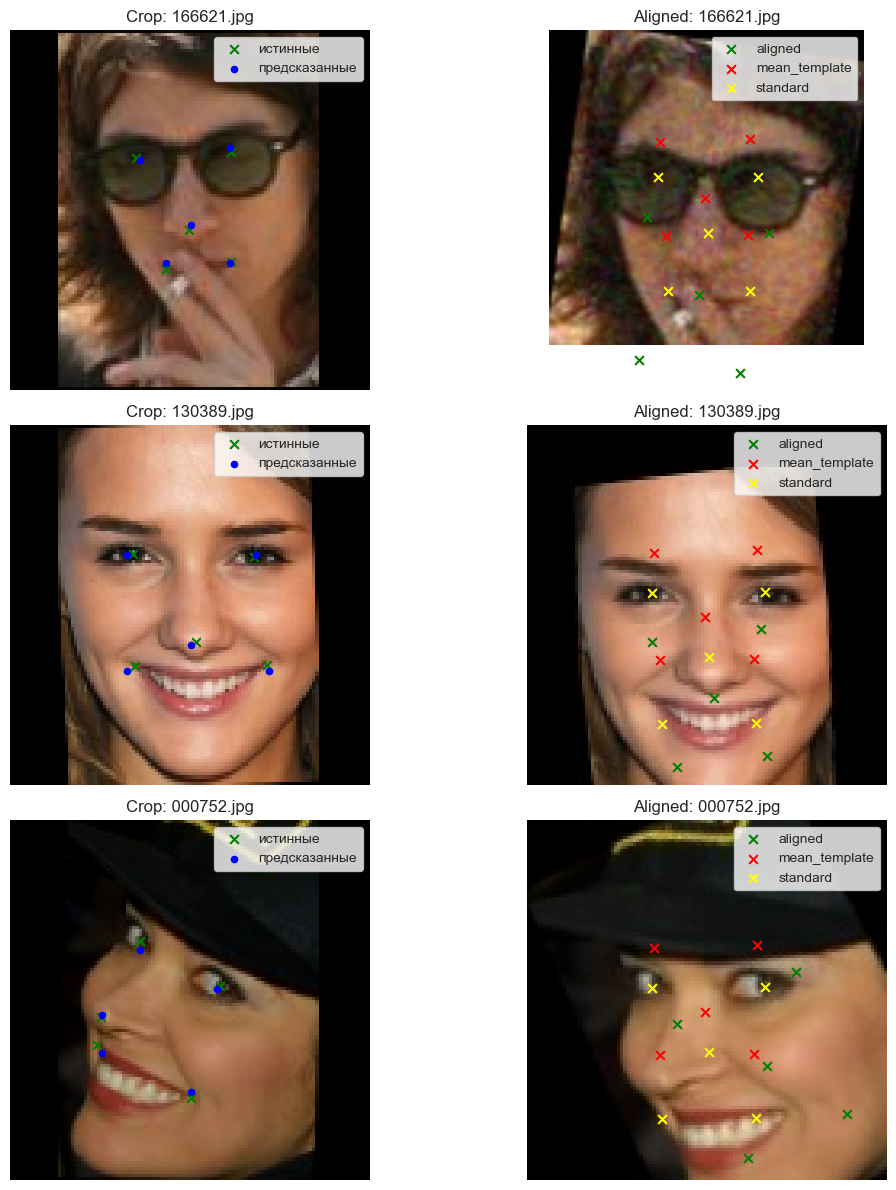

In [640]:
# Генерируем 3 случайных индекса
indices = random.sample(range(len(train_dataset)), 3)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    # получаем изображение из train_dataset (обрезанное)
    sample = train_dataset[idx]
    img_tensor = sample['image']
    img_id = sample['image_id']

    # извлекаем aligned_landmarks
    aligned_landmarks = np.array(train_aligned_df.loc[train_aligned_df['original_id'] == img_id, 'landmarks_aligned'].to_list())
    
    # денормализация для визуализации
    img_denorm = denormalize_image(img_tensor)
    
    # путь к выровненному изображению
    #aligned_id = f"{os.path.splitext(img_id)[0]}_aligned.jpg"
    aligned_id = img_id
    aligned_path = os.path.join(dir_aligned_mini, aligned_id)
    
    # получаем предсказанные landmarks
    model_shg.eval()
    with torch.no_grad():
        outputs = model_shg(img_tensor.unsqueeze(0).to(device))
        heatmaps = outputs[:, -1] if outputs.dim() == 5 else outputs
        pred_landmarks = model_shg.predict_landmarks(heatmaps).cpu().numpy()


    # отображаем в 2 колонки
    # обрезанное изображение
    plt.subplot(3, 2, i*2+1)
    plt.imshow(img_denorm)
    plt.scatter(sample['landmarks'][:, 0], sample['landmarks'][:, 1], c='green', s=40, marker='x', label='истинные') 
    plt.scatter(pred_landmarks[:, :, 0], pred_landmarks[:, :, 1], c='blue', s=20, marker='o', label='предсказанные')  # предсказанные landmarks [5, 2]
    plt.title(f'Crop: {img_id}')
    plt.legend()
    plt.axis('off')
    # выровненное изображение
    if os.path.exists(aligned_path):
        aligned_img = cv2.imread(aligned_path)
        aligned_img = cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 2, i*2+2)
        plt.imshow(aligned_img)
        plt.scatter(aligned_landmarks[:, :, 0], aligned_landmarks[:, :, 1], c='green', s=40, marker='x', label='aligned')
        plt.scatter(CUSTOM_TEMPLATE_LM[:, 0], CUSTOM_TEMPLATE_LM[:, 1], c='red', s=40, marker='x', label='mean_template')
        plt.scatter(STANDARD_LANDMARKS[:, 0], STANDARD_LANDMARKS[:, 1], c='yellow', s=40, marker='x', label='standard')
        plt.title(f'Aligned: {img_id}')
        plt.legend()
        plt.axis('off')
    else:
        plt.subplot(3, 2, i*2+2)
        plt.text(0.5, 0.5, 'Файл не найден', ha='center', va='center')
        plt.axis('off')

plt.tight_layout()
plt.savefig('compare_crop_aligned.png', bbox_inches='tight', dpi=100)
plt.show()

## Заключение

1. Собран стратифицированный мини набор данных изображений с их метаданными объемом в 11 тыс. изображений, 550 персон по 20 изображений. Выборка для каждого человека стратифицирована по 16 признакам/атрибутам.

2. Класс датасета трансформирует "сырые" изображения: делает обрезку по bbox'у с возможным дополнительным коэффициентом, пересчитывает координаты ключевых точек лица, реализует аугментацию изображений, приводит все изображения к размеру 112х112.

3. Модель StackedHourglass обучена на 80 эпохах и достигла результатов: лучший loss 0.0003; лучший NME 5.60%. Лучшие метрики достигнуты на 64 эпохе. Веса сохранены в файл checkpoints/best_model_nme_20260123_233506_epoch_64_nme_5.60.pt

4. Сформирован набор данных выровненных изображений для следующих этапов проекта по распознаванию лиц.
